In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import datetime as dt
import re
import warnings
warnings.filterwarnings("ignore")
# Setting baseline seed
np.random.seed(240911)

In [2]:
stock = 'SPY'
start = dt.datetime(2005, 11, 1)
end = dt.datetime(2024, 10, 31)
df = yf.download(stock, start, end)

[*********************100%%**********************]  1 of 1 completed


In [3]:
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2005-11-01,120.580002,120.900002,120.220001,120.489998,83.991119,66365100
2005-11-02,120.169998,121.750000,120.129997,121.750000,84.869438,74012300
2005-11-03,122.150002,122.660004,121.750000,122.269997,85.231956,84897600
2005-11-04,122.400002,122.459999,121.550003,122.110001,85.120392,59156000
2005-11-07,122.370003,122.620003,121.849998,122.230003,85.204056,46765400
...,...,...,...,...,...,...
2024-10-24,579.979980,580.059998,576.570007,579.239990,579.239990,34979900
2024-10-25,581.510010,584.460022,578.080017,579.039978,579.039978,47268200
2024-10-28,582.580017,582.710022,580.520020,580.830017,580.830017,30174700


## SMA Strategy

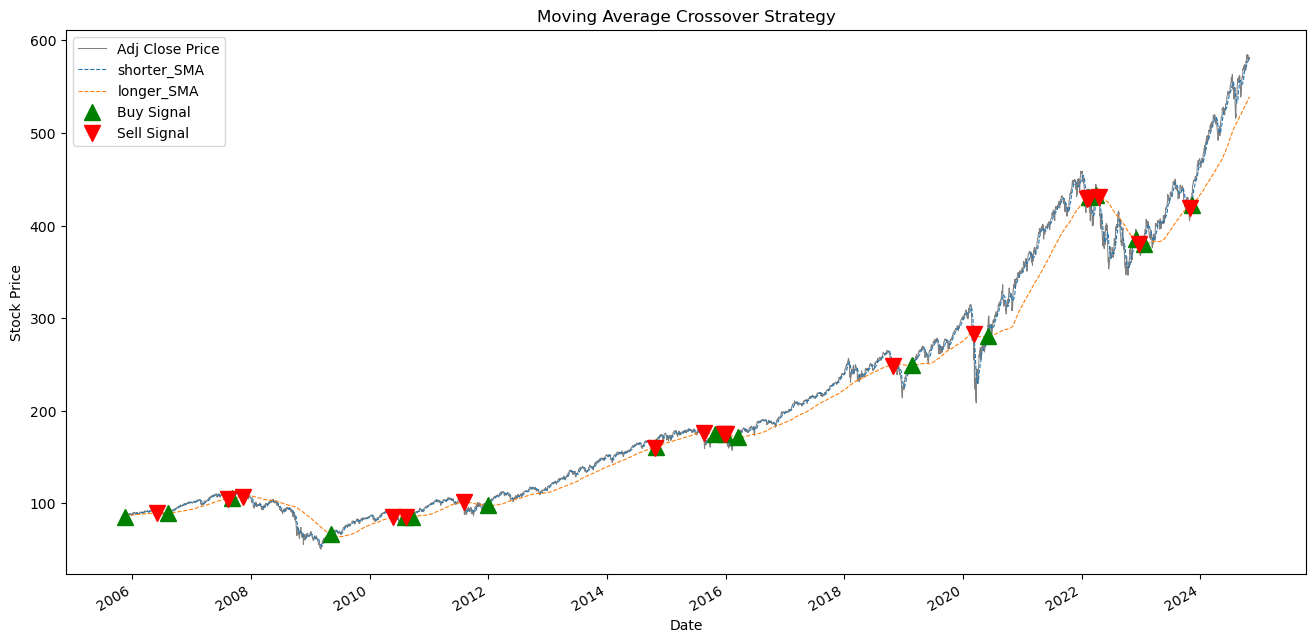

In [5]:
#SMA Trading Strategy (Version 2) with .diff create a trading signal for entry or exit

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def calculate_moving_average_strategy(data, short_window, long_window):
    # Calculate shorter and longer SMAs
    data['shorter_SMA'] = data['Adj Close'].rolling(window=short_window, min_periods=short_window).mean()
    data['longer_SMA'] = data['Adj Close'].rolling(window=long_window, min_periods=short_window).mean()
    
    # Generate buy (1) and sell (0) signals
    data['BUY_or_SELL'] = np.where(data['shorter_SMA'] > data['longer_SMA'], 1.0, 0.0)
    
    # Calculate positions as the difference in signals to identify trade points
    data['Positions'] = data['BUY_or_SELL'].diff()
    
    return data

def plot_moving_average_strategy(data):

    fig = plt.figure(figsize=[16, 8])
    ax = fig.add_subplot(111, ylabel="Stock Price")
    
    # Plot the stock price
    data['Adj Close'].plot(ax=ax, color="grey", linewidth=0.75, label="Adj Close Price")
    
    # Plot shorter and longer SMAs
    data[['shorter_SMA', 'longer_SMA']].plot(ax=ax, style=["--", "--"], linewidth=0.80)
    
    # Plot BUY signals
    ax.plot(data.loc[data['Positions'] == 1.0].index,          # x_axis
            data['shorter_SMA'][data['Positions'] == 1.0],     # y_axis
            "^", color="green", markersize=12, label="Buy Signal")
    
    # Plot SELL signals
    ax.plot(data.loc[data['Positions'] == -1.0].index,        # x_axis
            data['shorter_SMA'][data['Positions'] == -1.0],   # y_axis
            "v", color="red", markersize=12, label="Sell Signal")

    # Show legend and plot
    ax.legend(loc="best")
    plt.title("Moving Average Crossover Strategy")
    plt.show()


short_window = 13      # Tune!
long_window = 167       # Tune


# Calculate the strategy data
strategy_data = calculate_moving_average_strategy(df, short_window, long_window)
strategy_data

# Plot the results
plot_moving_average_strategy(strategy_data)        #REMEMBER TO RUN THE STRATEGY DATA FIRST, BEFORE RUN THE PLOTTING!


In [249]:
#BACKTESTING Using (CAPITAL vs Our HOLDINGS)

import pandas as pd

def portfolio_management(data, capital, position_size):

    # Initialize Position DataFrame based on 'BUY_or_SELL' signals
    Position = pd.DataFrame(index=data.index).fillna(0.0)
    Position["shares_bought"] = position_size * data["BUY_or_SELL"]

    # Calculate Portfolio holdings based on position and close prices
    Portfolio = Position.multiply(data["Adj Close"], axis=0)
    
    # Calculate difference in shares owned to track trades
    difference_in_shares_owned = Position.diff()

    # Calculate our holdings in terms of market value
    Portfolio["our_holdings"] = Portfolio["shares_bought"]

    # Calculate our cash balance by adjusting for trades
    Portfolio["our_cash"] = (
        capital
        - (difference_in_shares_owned.multiply(data["Adj Close"], axis=0).sum(axis=1)).cumsum()
    )

    # Total portfolio value (cash + holdings)
    Portfolio["total"] = Portfolio["our_cash"] + Portfolio["our_holdings"]

    # Calculate portfolio returns based on total value
    Portfolio["strategy_returns"] = np.log(Portfolio['total'] / Portfolio['total'].shift(1))

    Portfolio['cum_return'] = np.exp(Portfolio["strategy_returns"].cumsum())

    return Portfolio


# Assuming 'data' is a combined DataFrame with columns 'BUY_or_SELL' and 'Adj Close' for the asset
data = strategy_data    #TAKE FROM PREVIOUS FUNCTION!
portfolio_df = portfolio_management(data, capital=100000, position_size=749.5)        #TUNE!
portfolio_df.tail()


,shares_bought,our_holdings,our_cash,total,strategy_returns,cum_return
Date,,,,,,
2024-10-24,434140.372681,434140.372681,52.260536,434192.633217,0.002160,4.341926
2024-10-25,433990.463531,433990.463531,52.260536,434042.724068,-0.000345,4.340427
2024-10-28,435332.097809,435332.097809,52.260536,435384.358345,0.003086,4.353844
2024-10-29,436036.629639,436036.629639,52.260536,436088.890175,0.001617,4.360889
2024-10-30,434717.502319,434717.502319,52.260536,434769.762856,-0.003029,4.347698


In [7]:
sma_df = pd.DataFrame()
sma_df['SPY_return'] = np.log(df['Adj Close'] / df['Adj Close'].shift(1)) #LOG RETURN
sma_df['SPY_cum_return'] = np.exp(sma_df['SPY_return'].cumsum())  #NORMAL RETURN
sma_df['strategy_return'] = portfolio_df['strategy_returns']   #LOG RETURN
sma_df['cum_strategy_return'] = np.exp(portfolio_df['strategy_returns'].cumsum())   #NORMAL RETURN
sma_df.loc['2017':]

,SPY_return,SPY_cum_return,strategy_return,cum_strategy_return
Date,,,,
2017-01-03,0.007621,2.356831,0.007401,2.039051
2017-01-04,0.005932,2.370852,0.005762,2.050834
2017-01-05,-0.000795,2.368969,-0.000772,2.049251
2017-01-06,0.003571,2.377444,0.003469,2.056373
2017-01-09,-0.003306,2.369597,-0.003212,2.049779
...,...,...,...,...
2024-10-24,0.002160,6.896443,0.002293,5.461104
2024-10-25,-0.000345,6.894062,-0.000366,5.459103
2024-10-28,0.003087,6.915374,0.003275,5.477012


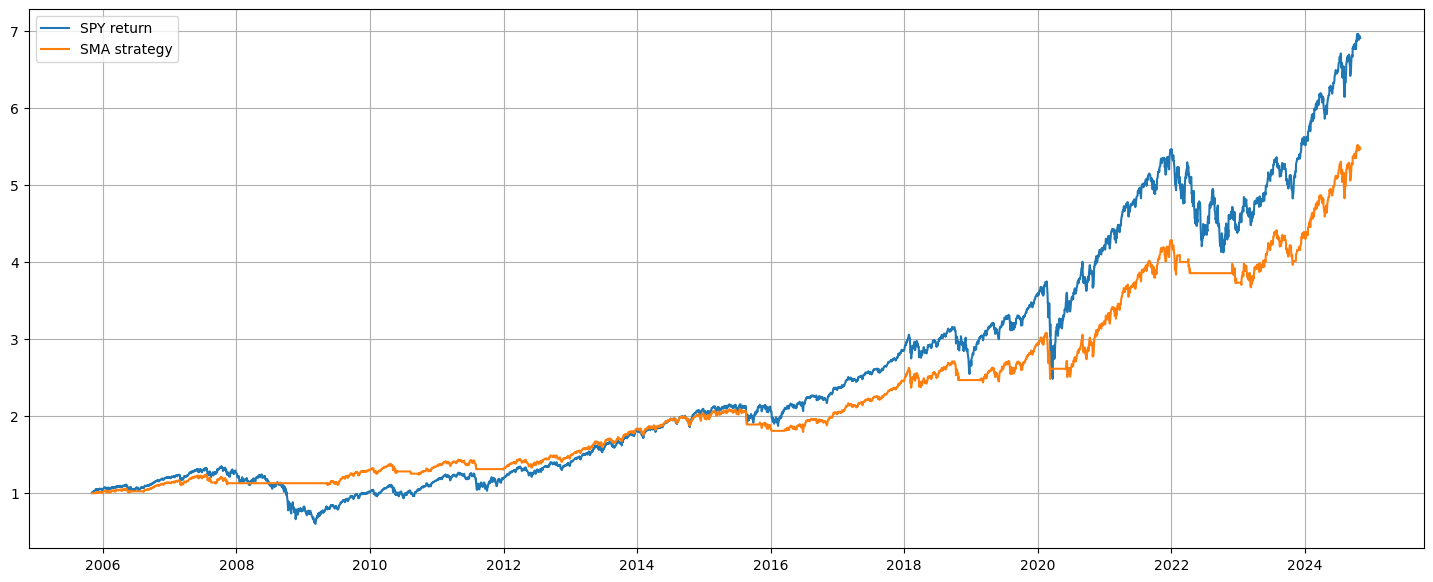

In [8]:
plt.figure(figsize = [18,7])
plt.plot(sma_df['SPY_cum_return'], label = 'SPY return')
plt.plot(sma_df['cum_strategy_return'], label = 'SMA strategy')
plt.legend()
plt.grid()

In [9]:
#TRY TO OPTIMIZE THE LONG SHORT WINDOW FOR SMA STRATEGY

In [10]:
import yfinance as yf

# Download S&P 500 data
data = df.loc['2017':]
data['SMA_Short'] = data['Adj Close'].rolling(window=short_window).mean()
data['SMA_Long'] = data['Adj Close'].rolling(window=long_window).mean()


In [247]:
import pandas as pd
import numpy as np

def backtest_sma_strategy(data, short_window, long_window):
    """
    Backtest SMA strategy.
    
    Parameters:
        data (pd.DataFrame): DataFrame with historical prices.
        short_window (int): Window size for short SMA.
        long_window (int): Window size for long SMA.
    
    Returns:
        float: Strategy return.
    """
    data['SMA_Short'] = data['Adj Close'].rolling(window=short_window).mean()
    data['SMA_Long'] = data['Adj Close'].rolling(window=long_window).mean()

    # Generate signals
    data['Signal'] = 0
    data.loc[data['SMA_Short'] > data['SMA_Long'], 'Signal'] = 1
    data.loc[data['SMA_Short'] <= data['SMA_Long'], 'Signal'] = -1

    # Calculate daily returns
    data['Daily_Return'] = data['Adj Close'].pct_change()
    data['Strategy_Return'] = data['Signal'].shift(1) * data['Daily_Return']

    # Calculate cumulative returns
    cumulative_strategy_return = np.exp(data['Strategy_Return'].sum())
    return cumulative_strategy_return



,shares_bought,our_holdings,our_cash,total,strategy_returns,cum_return
Date,,,,,,
2005-11-01,0.000000,0.000000,100000.000000,100000.000000,NaN,NaN
2005-11-02,0.000000,0.000000,100000.000000,100000.000000,0.000000,1.000000
2005-11-03,0.000000,0.000000,100000.000000,100000.000000,0.000000,1.000000
2005-11-04,0.000000,0.000000,100000.000000,100000.000000,0.000000,1.000000
2005-11-07,0.000000,0.000000,100000.000000,100000.000000,0.000000,1.000000
...,...,...,...,...,...,...
2024-10-24,434140.372681,434140.372681,52.260536,434192.633217,0.002160,4.341926
2024-10-25,433990.463531,433990.463531,52.260536,434042.724068,-0.000345,4.340427
2024-10-28,435332.097809,435332.097809,52.260536,435384.358345,0.003086,4.353844


In [12]:
best_return = -np.inf
best_short_window = None
best_long_window = None

for short_window in range(5, 21):  # Test short windows from 5 to 20
    for long_window in range(50, 201):  # Test long windows from 50 to 200
        if short_window >= long_window:
            continue
        strategy_return = backtest_sma_strategy(data.copy(), short_window, long_window)
        if strategy_return > best_return:
            best_return = strategy_return
            best_short_window = short_window
            best_long_window = long_window

print(f"Best Short Window: {best_short_window}")
print(f"Best Long Window: {best_long_window}")
print(f"Best Strategy Return: {best_return:.2f}")


Best Short Window: 7
Best Long Window: 116
Best Strategy Return: 2.31


In [13]:
#calculate sharpe ratio

In [14]:
#Sharpe Ratio V1 (where return is 1.00)

import numpy as np

def calculate_sharpe_ratio(returns, risk_free_rate=0):
    
    # Calculate the excess returns
    excess_returns = returns - risk_free_rate
    excess_returns = excess_returns - 1          #Need to be around 0.00 not 1.00, and need to be in original arithmetic scale
    
    # Calculate the mean and standard deviation of daily excess returns
    mean_excess_return = excess_returns.mean()
    std_excess_return = excess_returns.std()

    # Calculate the daily Sharpe ratio
    daily_sharpe_ratio = mean_excess_return / std_excess_return

    # Annualize the Sharpe ratio by multiplying by the square root of 252
    annualized_sharpe_ratio = daily_sharpe_ratio * np.sqrt(252)

    return annualized_sharpe_ratio


sharpe_ratio = calculate_sharpe_ratio(sma_df["SPY_return"])
print("Annualized Sharpe Ratio:", sharpe_ratio)


Annualized Sharpe Ratio: -1299.9764192028408


In [15]:
#CAGR

def calculate_cagr(cum_return):
    
    # Calculate the number of years in the period
    num_days = (cum_return.index[-1] - cum_return.index[0]).days

    # Calculate CAGR
    start_value = cum_return.iloc[0]
    end_value = cum_return.iloc[-1]
    cagr = (end_value / start_value) ** (365 / num_days) - 1

    return cagr  


# Assuming 'Portfolio' DataFrame has a 'total' column with portfolio values over time
cagr = calculate_cagr(portfolio_df["total"])   #can use cumulative_return column!!
print("CAGR:", cagr)

CAGR: 0.093502204860886


## MEAN REVERSION STRATEGY

In [59]:
#TRY MEAN REVERSION STRATEGY

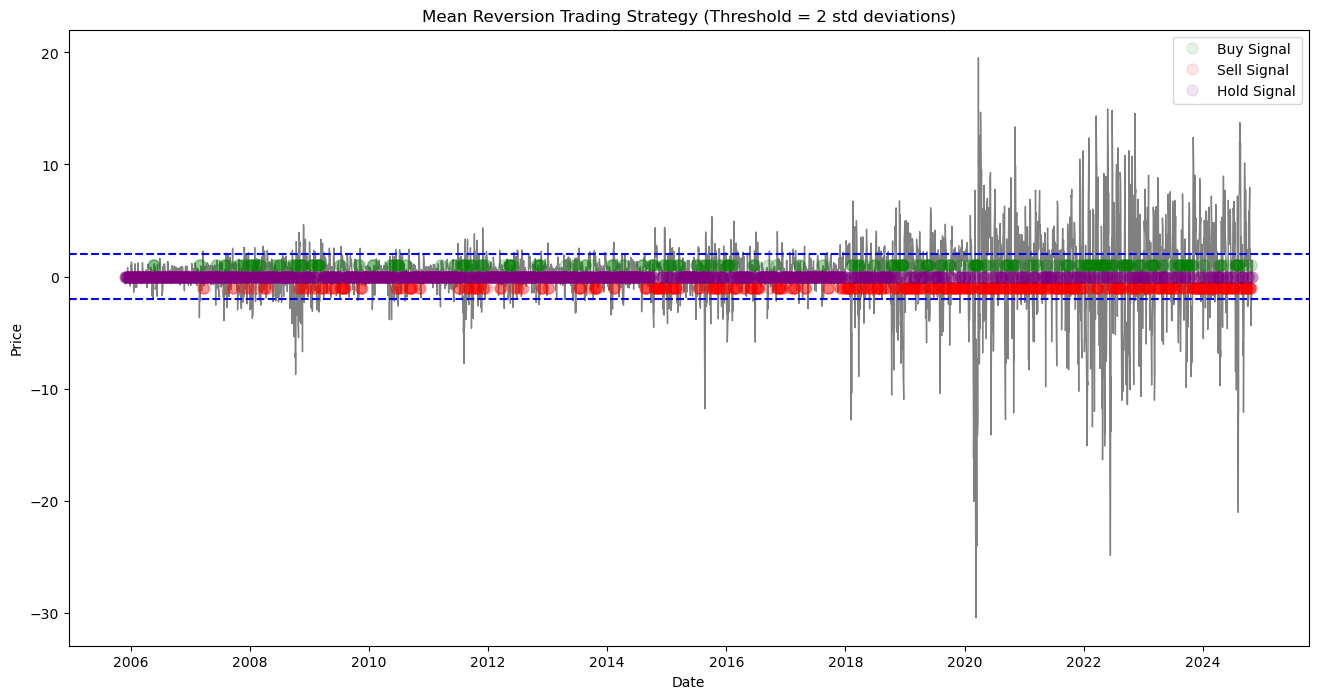

,price,SMA,distance,position
Date,,,,
2005-11-28,87.992393,88.015617,-0.023224,0.0
2005-11-29,87.894760,88.127145,-0.232385,0.0
2005-11-30,87.420776,88.086483,-0.665707,0.0
2005-12-01,88.313072,88.131802,0.181271,0.0
2005-12-02,88.424568,88.110886,0.313683,0.0
...,...,...,...,...
2024-10-24,579.239990,581.853333,-2.613342,1.0
2024-10-25,579.039978,581.301666,-2.261688,1.0
2024-10-28,580.830017,580.674998,0.155019,0.0


In [61]:
#MEAN REVERSION STRATEGY: trading strategy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def mean_reversion_strategy(data, window, threshold=1.5):

    # Initialize the DataFrame for signals
    signals = pd.DataFrame(index=data.index)
    signals['price'] = data

    # Calculate moving average and rolling standard deviation
    signals['SMA'] = data.rolling(window=window, min_periods=window).mean()
    # signals['std_dev'] = data.rolling(window=window, min_periods=window).std()

    # Calculate the z-score (distance from the mean in terms of std deviations)
    signals['distance'] = (signals['price'] - signals['SMA'])

    # Generate trading signals based on z-score
    signals['position'] = np.where(signals['distance'] > threshold, -1, np.nan)  # Buy when z-score is less than -threshold
    signals['position'] = np.where(signals['distance'] < -threshold, 1, signals['position'])  # Sell when z-score is more than +threshold
    signals['position'] = np.where(signals['distance'] * signals['distance'].shift(1) < 0 , 0, signals['position'])
    
    signals['position'] = signals['position'].ffill()

    signals = signals.dropna()

    return signals

def plot_mean_reversion_strategy(signals, threshold):

    fig, ax = plt.subplots(figsize=[16, 8])

    # Plot price and moving average
    ax.plot(signals['distance'], label='', color='grey', linewidth=1)
    # ax.plot(signals['SMA'], label=f'{signals["SMA"].name}-day Moving Average', color='blue', linestyle='--')

    # Plot buy and sell signals
    ax.plot(signals.loc[signals['position'] == 1].index, 
            signals['position'][signals['position'] == 1], 
            'o', markersize=8, color='green', label='Buy Signal', alpha = 0.1)

    ax.plot(signals.loc[signals['position'] == -1].index, 
            signals['position'][signals['position'] == -1], 
            'o', markersize=8, color='red', label='Sell Signal', alpha = 0.1)

    ax.plot(signals.loc[signals['position'] == 0].index, 
            signals['position'][signals['position'] == 0], 
            'o', markersize=8, color='purple', label='Hold Signal', alpha = 0.1)

    

    plt.axhline(threshold, color = "blue", ls = "--")

    # plt.axhline(0, color = "green", ls = "--")

    plt.axhline(-threshold, color = "blue", ls = "--")

    ax.set_xlabel('Date')
    ax.set_ylabel('Price')
    ax.legend(loc='best')
    plt.title(f"Mean Reversion Trading Strategy (Threshold = {threshold} std deviations)")
    plt.show()

# Assuming 'data' is a Series of asset prices
window = 6           # Tune the look-back window for the moving average and standard deviation
threshold = 2       # Tune the threshold for entering/exiting positions
data = df['Adj Close']      #Tune the dataframe

signals = mean_reversion_strategy(data, window, threshold)
plot_mean_reversion_strategy(signals, threshold)
signals

In [63]:
signals['SPY_return'] = np.log(signals['price'] / signals['price'].shift(1))   # log return
signals['strategy_return'] = signals['position'].shift(1) * signals['SPY_return']    #log return
signals['cum_SPY_return'] = signals['SPY_return'].cumsum()   #log return
signals['cum_strategy_return'] = signals['strategy_return'].cumsum()   #log return

In [65]:
signals

,price,SMA,distance,position,SPY_return,strategy_return,cum_SPY_return,cum_strategy_return
Date,,,,,,,,
2005-11-28,87.992393,88.015617,-0.023224,0.0,NaN,NaN,NaN,NaN
2005-11-29,87.894760,88.127145,-0.232385,0.0,-0.001110,-0.000000,-0.001110,0.000000
2005-11-30,87.420776,88.086483,-0.665707,0.0,-0.005407,-0.000000,-0.006517,0.000000
2005-12-01,88.313072,88.131802,0.181271,0.0,0.010155,0.000000,0.003638,0.000000
2005-12-02,88.424568,88.110886,0.313683,0.0,0.001262,0.000000,0.004899,0.000000
...,...,...,...,...,...,...,...,...
2024-10-24,579.239990,581.853333,-2.613342,1.0,0.002160,0.000000,1.884467,1.056780
2024-10-25,579.039978,581.301666,-2.261688,1.0,-0.000345,-0.000345,1.884121,1.056434
2024-10-28,580.830017,580.674998,0.155019,0.0,0.003087,0.003087,1.887208,1.059521


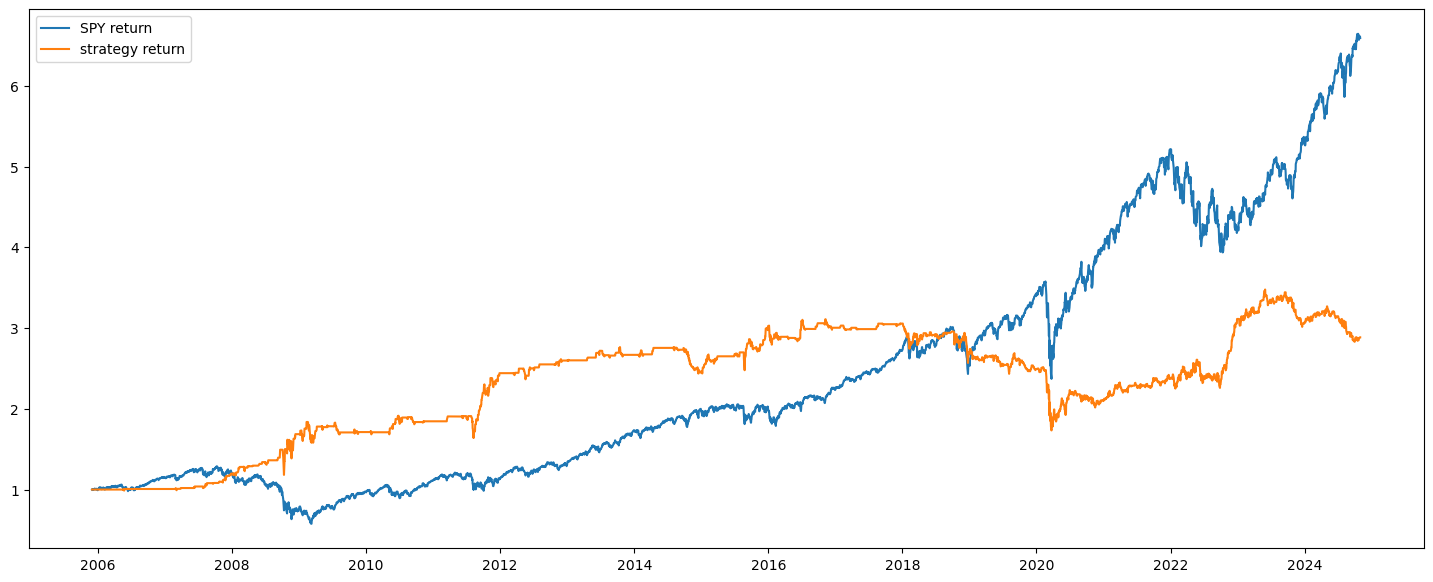

In [67]:
plt.figure(figsize = [18,7])
plt.plot(np.exp(signals['cum_SPY_return']), label = 'SPY return')
plt.plot(np.exp(signals['cum_strategy_return']), label = 'strategy return')
plt.legend()

In [22]:
#mean reversion strategy hyperparameter tuning

In [23]:
#MEAN REVERSION STRATEGY: trading strategy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def mean_reversion_strategy(data, window, threshold=1.5):

    # Initialize the DataFrame for signals
    signals = pd.DataFrame(index=data.index)
    signals['price'] = data

    # Calculate moving average and rolling standard deviation
    signals['SMA'] = data.rolling(window=window, min_periods=window).mean()
    # signals['std_dev'] = data.rolling(window=window, min_periods=window).std()

    # Calculate the z-score (distance from the mean in terms of std deviations)
    signals['distance'] = (signals['price'] - signals['SMA'])

    # Generate trading signals based on z-score
    signals['position'] = np.where(signals['distance'] > threshold, -1, np.nan)  # Buy when z-score is less than -threshold
    signals['position'] = np.where(signals['distance'] < -threshold, 1, signals['position'])  # Sell when z-score is more than +threshold
    signals['position'] = np.where(signals['distance'] * signals['distance'].shift(1) < 0 , 0, signals['position'])
    
    signals['position'] = signals['position'].ffill()

    signals = signals.dropna()

    return signals

def plot_mean_reversion_strategy(signals, threshold):

    fig, ax = plt.subplots(figsize=[16, 8])

    # Plot price and moving average
    ax.plot(signals['distance'], label='', color='grey', linewidth=1)
    # ax.plot(signals['SMA'], label=f'{signals["SMA"].name}-day Moving Average', color='blue', linestyle='--')

    # Plot buy and sell signals
    ax.plot(signals.loc[signals['position'] == 1].index, 
            signals['position'][signals['position'] == 1], 
            'o', markersize=8, color='green', label='Buy Signal', alpha = 0.1)

    ax.plot(signals.loc[signals['position'] == -1].index, 
            signals['position'][signals['position'] == -1], 
            'o', markersize=8, color='red', label='Sell Signal', alpha = 0.1)

    ax.plot(signals.loc[signals['position'] == 0].index, 
            signals['position'][signals['position'] == 0], 
            'o', markersize=8, color='purple', label='Hold Signal', alpha = 0.1)

    

    plt.axhline(threshold, color = "blue", ls = "--")

    # plt.axhline(0, color = "green", ls = "--")

    plt.axhline(-threshold, color = "blue", ls = "--")

    ax.set_xlabel('Date')
    ax.set_ylabel('Price')
    ax.legend(loc='best')
    plt.title(f"Mean Reversion Trading Strategy (Threshold = {threshold} std deviations)")
    plt.show()

window_list = np.arange(5,50)
threshold_list = np.arange(1,5)
cum_return_list = []

window_list2 = []
threshold_list2 = []
for window in window_list:
    for threshold in threshold_list:
        # Assuming 'data' is a Series of asset prices
        # window = window           # Tune the look-back window for the moving average and standard deviation
        # threshold = threshold_list       # Tune the threshold for entering/exiting positions
        data = df['Adj Close']      #Tune the dataframe

        signals = mean_reversion_strategy(data, window, threshold)
        # plot_mean_reversion_strategy(signals, threshold)


        signals['SPY_return'] = np.log(signals['price'] / signals['price'].shift(1))   # log return
        signals['strategy_return'] = signals['position'].shift(1) * signals['SPY_return']    #log return
        signals['cum_SPY_return'] = signals['SPY_return'].cumsum()   #log return
        signals['cum_strategy_return'] = signals['strategy_return'].cumsum()   #log return
        cum_return_list.append(signals['cum_strategy_return'].iloc[-1])
        window_list2.append(window)
        threshold_list2.append(threshold)

tuning_df = pd.DataFrame({'window' : window_list2,
                         'threshold': threshold_list2,
                         'cum_strategy_return' : cum_return_list})

tuning_df

,window,threshold,cum_strategy_return
0,5,1,0.841922
1,5,2,0.935107
2,5,3,0.764519
3,5,4,0.596054
4,6,1,0.516402
...,...,...,...
175,48,4,-0.350643
176,49,1,-0.074086
177,49,2,-0.103870
178,49,3,-0.183603


In [24]:
tuning_df[tuning_df.cum_strategy_return == tuning_df.cum_strategy_return.max()]

,window,threshold,cum_strategy_return
5,6,2,1.059521


## Combine SMA with Mean Reversion

In [85]:
#Mean Reversion
new_signals = signals.loc[:'2016']

In [115]:
new_signals = new_signals.rename(columns = {'cum_SPY_return' : 'SPY_cum_return'})

In [139]:
new_signals['SPY_cum_return'] = np.exp(new_signals['SPY_cum_return'])
new_signals['cum_strategy_return'] = np.exp(new_signals['cum_strategy_return'])
new_signals

,price,SMA,distance,position,SPY_return,strategy_return,SPY_cum_return,cum_strategy_return
Date,,,,,,,,
2005-11-28,87.992393,88.015617,-0.023224,0.0,NaN,NaN,NaN,NaN
2005-11-29,87.894760,88.127145,-0.232385,0.0,-0.001110,-0.0,0.998890,1.000000
2005-11-30,87.420776,88.086483,-0.665707,0.0,-0.005407,-0.0,0.993504,1.000000
2005-12-01,88.313072,88.131802,0.181271,0.0,0.010155,0.0,1.003644,1.000000
2005-12-02,88.424568,88.110886,0.313683,0.0,0.001262,0.0,1.004912,1.000000
...,...,...,...,...,...,...,...,...
2016-12-23,198.365936,198.302933,0.063004,0.0,0.001463,0.0,2.254353,3.003592
2016-12-27,198.858139,198.483109,0.375031,0.0,0.002478,0.0,2.259947,3.003592
2016-12-28,197.214645,198.317599,-1.102954,0.0,-0.008299,-0.0,2.241269,3.003592


In [154]:
#SMA
new_sma_df = sma_df.loc['2017':]

In [181]:
new_sma_df['cum_strategy_return'] = (new_sma_df['cum_strategy_return'] 
                                         - new_sma_df['cum_strategy_return'][0] 
                                         + new_signals['cum_strategy_return'][-1])
new_sma_df

,SPY_return,SPY_cum_return,strategy_return,cum_strategy_return,adj_cum_strategy_return
Date,,,,,
2017-01-03,0.007621,2.356831,0.007401,3.003592,3.003592
2017-01-04,0.005932,2.370852,0.005762,3.015374,3.015374
2017-01-05,-0.000795,2.368969,-0.000772,3.013791,3.013791
2017-01-06,0.003571,2.377444,0.003469,3.020914,3.020914
2017-01-09,-0.003306,2.369597,-0.003212,3.014320,3.014320
...,...,...,...,...,...
2024-10-24,0.002160,6.896443,0.002293,6.425645,6.425645
2024-10-25,-0.000345,6.894062,-0.000366,6.423643,6.423643
2024-10-28,0.003087,6.915374,0.003275,6.441553,6.441553


In [183]:
combined_df = pd.DataFrame()

In [185]:
combined_df = pd.concat([new_signals[['SPY_cum_return','cum_strategy_return']], new_sma_df[['SPY_cum_return','cum_strategy_return']]])

In [187]:
combined_df

,SPY_cum_return,cum_strategy_return
Date,,
2005-11-28,NaN,NaN
2005-11-29,0.998890,1.000000
2005-11-30,0.993504,1.000000
2005-12-01,1.003644,1.000000
2005-12-02,1.004912,1.000000
...,...,...
2024-10-24,6.896443,6.425645
2024-10-25,6.894062,6.423643
2024-10-28,6.915374,6.441553


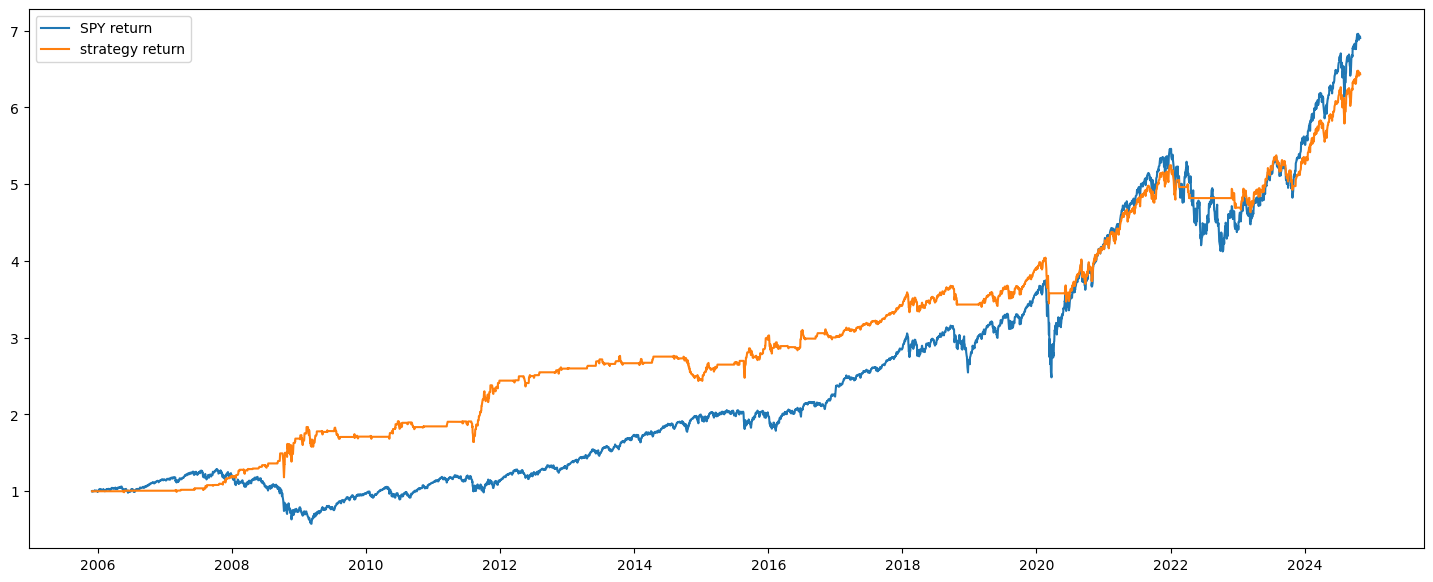

In [189]:
plt.figure(figsize = [18,7])
plt.plot(combined_df['SPY_cum_return'], label = 'SPY return')
plt.plot(combined_df['cum_strategy_return'], label = 'strategy return')
plt.legend()

## LOGISTIC REGRESSION

[*********************100%%**********************]  1 of 1 completed

Accuracy Score:  0.5526481055055474


,Open,High,Low,Close,Adj Close,Volume,return,lag_1,lag_2,lag_3,prediction,strategy
Date,,,,,,,,,,,,
2005-11-07,122.370003,122.620003,121.849998,122.230003,85.204056,46765400,0.000982,-0.001310,0.004262,0.010403,1.0,0.000982
2005-11-08,121.930000,122.419998,121.790001,122.230003,85.204056,42152800,0.000000,0.000982,-0.001310,0.004262,1.0,0.000000
2005-11-09,122.080002,122.949997,121.860001,122.389999,85.315605,57666800,0.001308,0.000000,0.000982,-0.001310,1.0,0.001308
2005-11-10,122.339996,123.519997,121.750000,123.339996,85.977806,79048100,0.007732,0.001308,0.000000,0.000982,1.0,0.007732
2005-11-11,123.349998,123.839996,122.430000,123.760002,86.270584,34867000,0.003399,0.007732,0.001308,0.000000,1.0,0.003399
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-24,579.979980,580.059998,576.570007,579.239990,579.239990,34979900,0.002160,-0.009179,-0.000531,-0.001644,1.0,0.002160
2024-10-25,581.510010,584.460022,578.080017,579.039978,579.039978,47268200,-0.000345,0.002160,-0.009179,-0.000531,1.0,-0.000345
2024-10-28,582.580017,582.710022,580.520020,580.830017,580.830017,30174700,0.003087,-0.000345,0.002160,-0.009179,1.0,0.003087


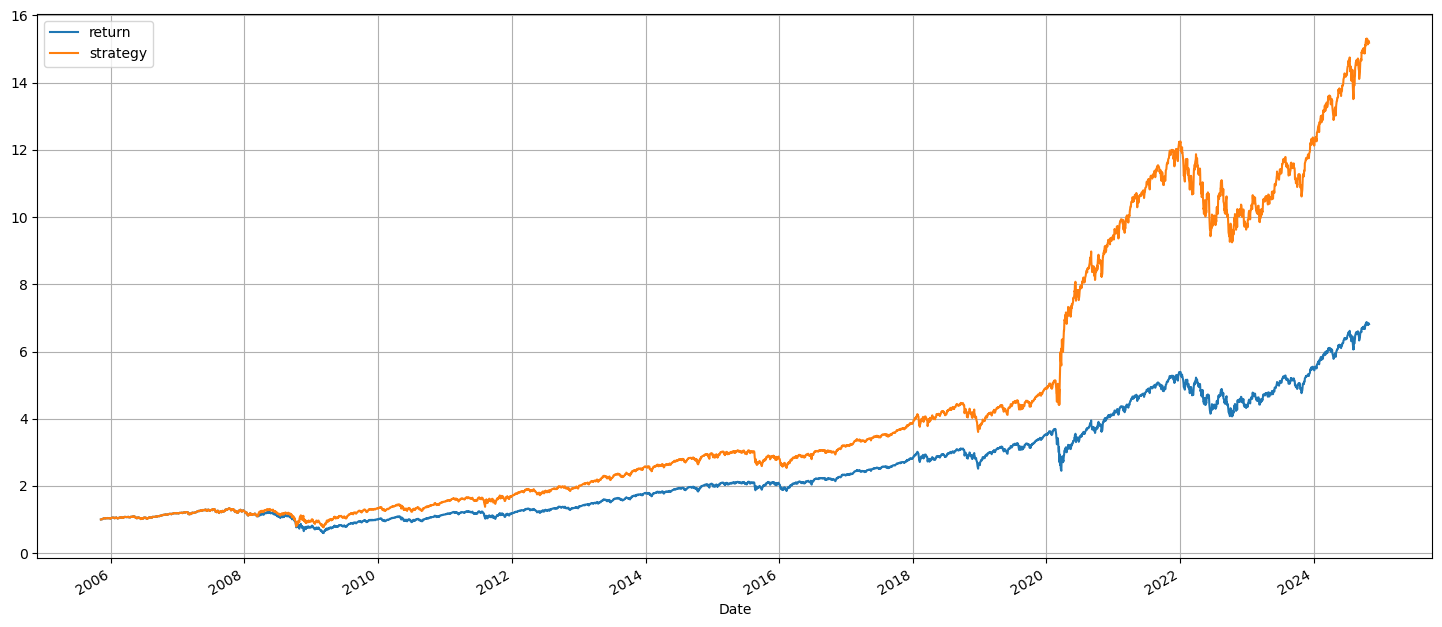

In [289]:
#Logistic Regression
from sklearn import linear_model
from sklearn.metrics import accuracy_score


stock = 'SPY'
start = dt.datetime(2005, 11, 1)
end = dt.datetime(2024, 10, 31)



def logistic_regression (stock , lags):
    df = yf.download(stock, start, end)
    df['return'] = np.log(df['Adj Close'] / df['Adj Close'].shift(1))
    df = df.dropna()

    cols = []

    for lag in range(1, lags +1):
        col = "lag_{}".format(lag)
        df[col] = df["return"].shift(lag)
        cols.append(col)

    df = df.dropna()

    M = linear_model.LogisticRegression(solver = "lbfgs",
                                        C = 1e7,
                                        multi_class = "auto",
                                        max_iter = 1000)
    
    M.fit(df[cols], np.sign(df["return"]))

    df['prediction'] = M.predict(df[cols])

    accuracy = np.sign(df["return"].iloc[lags:] * df["prediction"].iloc[lags:]).value_counts()
    
    acc_score = accuracy_score(df["prediction"], np.sign(df["return"]))
    
    print('Accuracy Score: ', acc_score)
    df["strategy"] = df["prediction"] * df["return"]   #strategy and return are both in np.log scale. Plotting needs np.exp

    return df


regression_df = pd.DataFrame()
regression_df = logistic_regression (stock , 3)

regression_df
# regression_df = pd.DataFrame()
# regression_df = logistic_regression (stock , 5)
# regression_df[['return','strategy']].cumsum().apply(np.exp).plot(figsize = [18,8], grid = True)

In [297]:
regression_summary = regression_df.copy()
regression_summary = regression_summary[['return','prediction', 'strategy']]
regression_summary

,return,prediction,strategy
Date,,,
2005-11-07,0.000982,1.0,0.000982
2005-11-08,0.000000,1.0,0.000000
2005-11-09,0.001308,1.0,0.001308
2005-11-10,0.007732,1.0,0.007732
2005-11-11,0.003399,1.0,0.003399
...,...,...,...
2024-10-24,0.002160,1.0,0.002160
2024-10-25,-0.000345,1.0,-0.000345
2024-10-28,0.003087,1.0,0.003087


In [303]:
regression_summary['cum_SPY_return'] = regression_summary['return'].cumsum().apply(np.exp)
regression_summary['cum_strategy_return'] = regression_summary['strategy'].cumsum().apply(np.exp)
regression_summary.tail()

,return,prediction,strategy,cum_SPY_return,cum_strategy_return
Date,,,,,
2024-10-24,0.002160,1.0,0.002160,6.804950,15.172540
2024-10-25,-0.000345,1.0,-0.000345,6.802600,15.167301
2024-10-28,0.003087,1.0,0.003087,6.823630,15.214189
2024-10-29,0.001617,1.0,0.001617,6.834673,15.238811
2024-10-30,-0.003030,1.0,-0.003030,6.813996,15.192710


<Axes: xlabel='Date'>

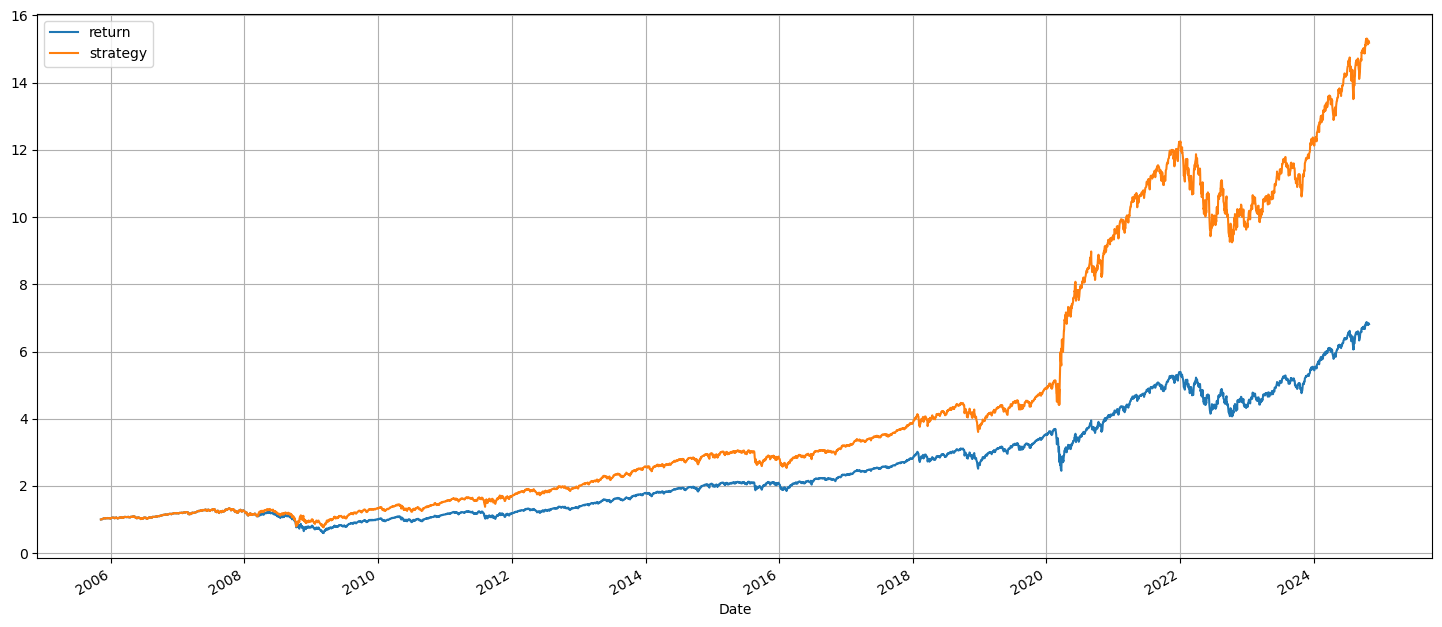

In [301]:
regression_df[['return','strategy']].cumsum().apply(np.exp).plot(figsize = [18,8], grid = True)

In [305]:
#logistic regression with train test data

[*********************100%%**********************]  1 of 1 completed

Test Accuracy Score: 0.5345188284518828


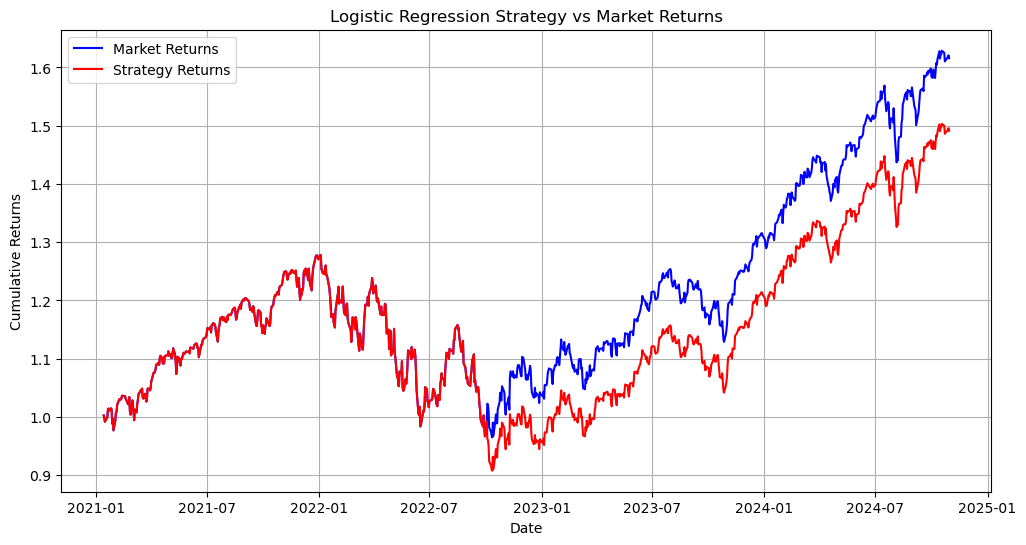

In [372]:
import numpy as np
import pandas as pd
import yfinance as yf
import datetime as dt
from sklearn import linear_model
from sklearn.metrics import accuracy_score

stock = 'SPY'
start = dt.datetime(2005, 11, 1)
end = dt.datetime(2024, 10, 31)

def logistic_regression_with_split(stock, lags, split_ratio=0.8):
    df = yf.download(stock, start, end)
    df['return'] = np.log(df['Adj Close'] / df['Adj Close'].shift(1))
    df = df.dropna()

    cols = []

    for lag in range(1, lags + 1):
        col = f"lag_{lag}"
        df[col] = df["return"].shift(lag)
        cols.append(col)

    df = df.dropna()

    # Split the data into train and test sets
    split_index = int(len(df) * split_ratio)
    train_data = df.iloc[:split_index]
    test_data = df.iloc[split_index:]

    # Logistic Regression Model
    M = linear_model.LogisticRegression(solver="lbfgs",
                                        C=1e7,
                                        multi_class="auto",
                                        max_iter=1000)

    # Train the model
    M.fit(train_data[cols], np.sign(train_data["return"]))

    # Predictions
    test_data['prediction'] = M.predict(test_data[cols])

    # Calculate accuracy
    accuracy = accuracy_score(np.sign(test_data["return"]), test_data["prediction"])
    print('Test Accuracy Score:', accuracy)

    # Strategy returns
    test_data["strategy"] = test_data["prediction"] * test_data["return"]

    return train_data, test_data

# Run the logistic regression function
train_data, test_data = logistic_regression_with_split(stock, 3)

# Plot strategy vs market returns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(np.exp(test_data['return'].cumsum()), label='Market Returns', color='blue')
plt.plot(np.exp(test_data['strategy'].cumsum()), label='Strategy Returns', color='red')
plt.title('Logistic Regression Strategy vs Market Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid()
plt.show()


In [429]:
#test train split logistic regression

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Running for lag=1...
Test Accuracy Score: 0.5355648535564853
Running for lag=2...
Test Accuracy Score: 0.5345188284518828
Running for lag=3...
Test Accuracy Score: 0.5345188284518828
Running for lag=4...
Test Accuracy Score: 0.5345188284518828
Running for lag=5...
Test Accuracy Score: 0.53717277486911
Running for lag=6...



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Test Accuracy Score: 0.5403141361256545
Running for lag=7...
Test Accuracy Score: 0.5403141361256545
Running for lag=8...
Test Accuracy Score: 0.5403141361256545
Running for lag=9...
Test Accuracy Score: 0.5392670157068062
Running for lag=10...
Test Accuracy Score: 0.5408805031446541
Running for lag=11...
Test Accuracy Score: 0.5461215932914046
Running for lag=12...


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Test Accuracy Score: 0.5440251572327044
Running for lag=13...
Test Accuracy Score: 0.5440251572327044
Running for lag=14...
Test Accuracy Score: 0.5419287211740041
Running for lag=15...
Test Accuracy Score: 0.5424973767051416
Running for lag=16...
Test Accuracy Score: 0.5435466946484785
Running for lag=17...
Test Accuracy Score: 0.5414480587618048
Running for lag=18...


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Test Accuracy Score: 0.5414480587618048
Running for lag=19...
Test Accuracy Score: 0.5414480587618048
    Lag  Cumulative Strategy Return
0     1                    0.460657
1     2                    0.437295
2     3                    0.399625
3     4                    0.399625
4     5                    0.445228
5     6                    0.478467
6     7                    0.478467
7     8                    0.480560
8     9                    0.471509
9    10                    0.486630
10   11                    0.624321
11   12                    0.550887
12   13                    0.521544
13   14                    0.463554
14   15                    0.529762
15   16                    0.560041
16   17                    0.513415
17   18                    0.437734
18   19                    0.437734


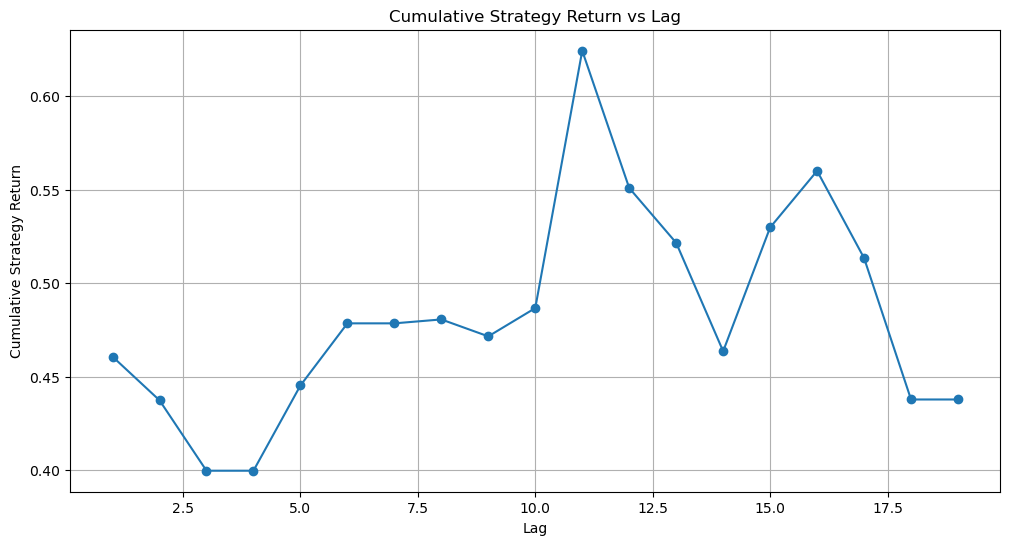

,Open,High,Low,Close,Adj Close,Volume,return,lag_1,lag_2,lag_3,...,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,prediction,strategy,cum_SPY_return,cum_strategy_return
Date,,,,,,,,,,,,,,,,,,,,,
2021-01-19,378.339996,379.230011,376.750000,378.649994,358.815186,51233300,0.007821,-0.007319,-0.003508,0.002689,...,0.008554,0.003883,0.000898,-0.001687,-0.003582,-0.004001,1.0,0.007821,0.007821,0.007821
2021-01-20,381.109985,384.790009,380.690002,383.890015,363.780640,61836100,0.013744,0.007821,-0.007319,-0.003508,...,-0.001910,0.008554,0.003883,0.000898,-0.001687,-0.003582,1.0,0.013744,0.021565,0.021565
2021-01-21,384.489990,384.950012,383.250000,384.239990,364.112366,47840100,0.000911,0.013744,0.007821,-0.007319,...,0.001426,-0.001910,0.008554,0.003883,0.000898,-0.001687,1.0,0.000911,0.022476,0.022476
2021-01-22,382.250000,384.130005,381.839996,382.880005,362.823578,52860500,-0.003546,0.000911,0.013744,0.007821,...,0.005068,0.001426,-0.001910,0.008554,0.003883,0.000898,1.0,-0.003546,0.018931,0.018931
2021-01-25,383.670013,384.769989,378.459991,384.390015,364.254456,70402000,0.003936,-0.003546,0.000911,0.013744,...,-0.013708,0.005068,0.001426,-0.001910,0.008554,0.003883,1.0,0.003936,0.022867,0.022867
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-24,579.979980,580.059998,576.570007,579.239990,579.239990,34979900,0.002160,-0.009179,-0.000531,-0.001644,...,0.009046,-0.001830,0.000422,-0.008999,0.003999,-0.001451,1.0,0.002160,0.486731,0.436406
2024-10-25,581.510010,584.460022,578.080017,579.039978,579.039978,47268200,-0.000345,0.002160,-0.009179,-0.000531,...,-0.009082,0.009046,-0.001830,0.000422,-0.008999,0.003999,1.0,-0.000345,0.486386,0.436061
2024-10-28,582.580017,582.710022,580.520020,580.830017,580.830017,30174700,0.003087,-0.000345,0.002160,-0.009179,...,0.009413,-0.009082,0.009046,-0.001830,0.000422,-0.008999,1.0,0.003087,0.489472,0.439147


In [525]:
#HYPERPARAMETER TUNING TO SEE WHICH LAG IS BEST
import numpy as np
import pandas as pd
import yfinance as yf
import datetime as dt
from sklearn import linear_model
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Set stock and date range
stock = 'SPY'
start = dt.datetime(2005, 11, 1)
end = dt.datetime(2024, 10, 31)

# Logistic Regression with Train-Test Split
def logistic_regression_with_split(stock, lags, split_ratio=0.8):
    # Download data
    df = yf.download(stock, start, end)
    df['return'] = np.log(df['Adj Close'] / df['Adj Close'].shift(1))
    df = df.dropna()

    # Create lagged features
    cols = []
    for lag in range(1, lags + 1):
        col = f"lag_{lag}"
        df[col] = df["return"].shift(lag)
        cols.append(col)

    df = df.dropna()

    # Train-test split
    split_index = int(len(df) * split_ratio)
    train_data = df.iloc[:split_index]
    test_data = df.iloc[split_index:]

    # Logistic Regression Model
    M = linear_model.LogisticRegression(solver="lbfgs",
                                        C=1e7,
                                        multi_class="auto",
                                        max_iter=1000)

    # Train the model
    M.fit(train_data[cols], np.sign(train_data["return"]))

    # Predictions on train and test data
    train_data['prediction'] = M.predict(train_data[cols])
    test_data['prediction'] = M.predict(test_data[cols])

    # Calculate accuracy for test set
    accuracy = accuracy_score(np.sign(test_data["return"]), test_data["prediction"])
    print('Test Accuracy Score:', accuracy)

    # Strategy returns
    train_data["strategy"] = train_data["prediction"] * train_data["return"]
    test_data["strategy"] = test_data["prediction"] * test_data["return"]

    return train_data, test_data

list_cum_strategy = []
lag_values = range(1, 20)  # Example: Test lag values from 1 to 10

# Run logistic regression for different lag values
for lag in lag_values:
    print(f"Running for lag={lag}...")
    train_data, test_data = logistic_regression_with_split(stock, lag)
    
    # Calculate cumulative returns for SPY and strategy
    test_data['cum_SPY_return'] = test_data['return'].cumsum()
    test_data['cum_strategy_return'] = test_data['strategy'].cumsum()
    
    # Collect final cumulative strategy return for the current lag
    list_cum_strategy.append((lag, test_data['cum_strategy_return'].iloc[-1]))

# Convert results to a DataFrame for analysis
strategy_results = pd.DataFrame(list_cum_strategy, columns=['Lag', 'Cumulative Strategy Return'])

# Display the results
print(strategy_results)

# Plot cumulative strategy return vs lag values
plt.figure(figsize=(12, 6))
plt.plot(strategy_results['Lag'], strategy_results['Cumulative Strategy Return'], marker='o')
plt.title('Cumulative Strategy Return vs Lag')
plt.xlabel('Lag')
plt.ylabel('Cumulative Strategy Return')
plt.grid()
plt.show()


test_data

In [526]:
train_data, test_data = logistic_regression_with_split(stock, 11)
    
# Calculate cumulative returns for SPY and strategy
test_data['cum_SPY_return'] = test_data['return'].cumsum()
test_data['cum_strategy_return'] = test_data['strategy'].cumsum()

[*********************100%%**********************]  1 of 1 completed

Test Accuracy Score: 0.5461215932914046


In [528]:
train_data['cum_SPY_return'] = train_data['return'].cumsum()
train_data['cum_strategy_return'] = train_data['strategy'].cumsum()
train_data

,Open,High,Low,Close,Adj Close,Volume,return,lag_1,lag_2,lag_3,...,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,prediction,strategy,cum_SPY_return,cum_strategy_return
Date,,,,,,,,,,,,,,,,,,,,,
2005-11-17,123.680000,124.650002,123.139999,124.639999,86.884026,55717500,0.009270,0.002027,-0.003645,-0.000566,...,0.001308,0.000000,0.000982,-0.001310,0.004262,0.010403,1.0,0.009270,0.009270,0.009270
2005-11-18,125.059998,125.279999,124.330002,125.129997,87.225594,72437200,0.003924,0.009270,0.002027,-0.003645,...,0.007732,0.001308,0.000000,0.000982,-0.001310,0.004262,1.0,0.003924,0.013193,0.013193
2005-11-21,125.150002,125.910004,124.980003,125.760002,87.664749,50021200,0.005022,0.003924,0.009270,0.002027,...,0.003399,0.007732,0.001308,0.000000,0.000982,-0.001310,1.0,0.005022,0.018215,0.018215
2005-11-22,125.559998,126.519997,125.419998,126.300003,88.041161,66438800,0.004285,0.005022,0.003924,0.009270,...,-0.000566,0.003399,0.007732,0.001308,0.000000,0.000982,1.0,0.004285,0.022500,0.022500
2005-11-23,126.250000,127.410004,126.209999,127.029999,88.550064,50854700,0.005764,0.004285,0.005022,0.003924,...,-0.003645,-0.000566,0.003399,0.007732,0.001308,0.000000,1.0,0.005764,0.028264,0.028264
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-08,380.589996,381.489990,377.100006,381.260010,361.288452,71677200,0.005682,0.014748,0.005961,0.006864,...,0.001426,-0.001910,0.008554,0.003883,0.000898,-0.001687,1.0,0.005682,1.434372,2.277272
2021-01-11,377.850006,380.579987,377.720001,378.690002,358.853058,51034700,-0.006764,0.005682,0.014748,0.005961,...,0.005068,0.001426,-0.001910,0.008554,0.003883,0.000898,1.0,-0.006764,1.427608,2.270509
2021-01-12,378.890015,379.859985,376.359985,378.769989,358.928894,52547700,0.000211,-0.006764,0.005682,0.014748,...,-0.013708,0.005068,0.001426,-0.001910,0.008554,0.003883,1.0,0.000211,1.427820,2.270720


In [531]:
test_data['cum_SPY_return'] = (test_data['cum_SPY_return'] 
                               + train_data['cum_SPY_return'][-1] 
                               - test_data['cum_SPY_return'][0])

test_data['cum_strategy_return'] = (test_data['cum_strategy_return'] 
                                    + train_data['cum_strategy_return'][-1]
                                    - test_data['cum_strategy_return'][0])

test_data

,Open,High,Low,Close,Adj Close,Volume,return,lag_1,lag_2,lag_3,...,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,prediction,strategy,cum_SPY_return,cum_strategy_return
Date,,,,,,,,,,,,,,,,,,,,,
2021-01-15,376.720001,377.579987,373.700012,375.700012,356.019684,107160000,-0.007319,-0.003508,0.002689,0.000211,...,0.014748,0.005961,0.006864,-0.013708,0.005068,0.001426,1.0,-0.007319,1.427001,2.269901
2021-01-19,378.339996,379.230011,376.750000,378.649994,358.815186,51233300,0.007821,-0.007319,-0.003508,0.002689,...,0.005682,0.014748,0.005961,0.006864,-0.013708,0.005068,1.0,0.007821,1.434822,2.277722
2021-01-20,381.109985,384.790009,380.690002,383.890015,363.780640,61836100,0.013744,0.007821,-0.007319,-0.003508,...,-0.006764,0.005682,0.014748,0.005961,0.006864,-0.013708,1.0,0.013744,1.448566,2.291466
2021-01-21,384.489990,384.950012,383.250000,384.239990,364.112366,47840100,0.000911,0.013744,0.007821,-0.007319,...,0.000211,-0.006764,0.005682,0.014748,0.005961,0.006864,1.0,0.000911,1.449477,2.292378
2021-01-22,382.250000,384.130005,381.839996,382.880005,362.823578,52860500,-0.003546,0.000911,0.013744,0.007821,...,0.002689,0.000211,-0.006764,0.005682,0.014748,0.005961,1.0,-0.003546,1.445932,2.288832
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-24,579.979980,580.059998,576.570007,579.239990,579.239990,34979900,0.002160,-0.009179,-0.000531,-0.001644,...,0.004337,-0.007800,0.008145,0.005970,-0.001752,0.006903,1.0,0.002160,1.913732,2.900213
2024-10-25,581.510010,584.460022,578.080017,579.039978,579.039978,47268200,-0.000345,0.002160,-0.009179,-0.000531,...,0.000086,0.004337,-0.007800,0.008145,0.005970,-0.001752,1.0,-0.000345,1.913386,2.899868
2024-10-28,582.580017,582.710022,580.520020,580.830017,580.830017,30174700,0.003087,-0.000345,0.002160,-0.009179,...,0.003839,0.000086,0.004337,-0.007800,0.008145,0.005970,1.0,0.003087,1.916473,2.902954


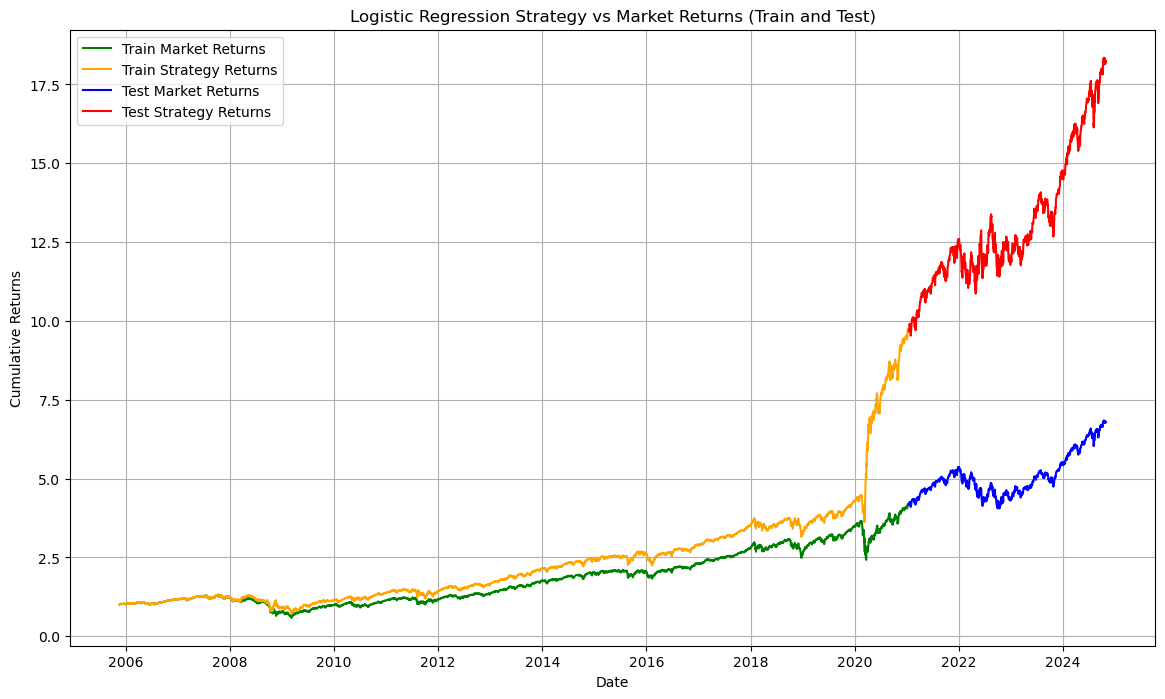

In [533]:
# Combined plotting for train and test data
plt.figure(figsize=(14, 8))
# Train Data: Market and Strategy Returns
plt.plot(np.exp(train_data['return'].cumsum()), label='Train Market Returns', color='green', linestyle='-')
plt.plot(np.exp(train_data['strategy'].cumsum()), label='Train Strategy Returns', color='orange', linestyle='-')

# Test Data: Market and Strategy Returns
plt.plot(np.exp(test_data['cum_SPY_return']), label='Test Market Returns', color='blue', linestyle='-')
plt.plot(np.exp(test_data['cum_strategy_return']), label='Test Strategy Returns', color='red', linestyle='-')

# Plot configuration
plt.title('Logistic Regression Strategy vs Market Returns (Train and Test)')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid()
plt.show()

In [535]:
test_data

,Open,High,Low,Close,Adj Close,Volume,return,lag_1,lag_2,lag_3,...,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,prediction,strategy,cum_SPY_return,cum_strategy_return
Date,,,,,,,,,,,,,,,,,,,,,
2021-01-15,376.720001,377.579987,373.700012,375.700012,356.019684,107160000,-0.007319,-0.003508,0.002689,0.000211,...,0.014748,0.005961,0.006864,-0.013708,0.005068,0.001426,1.0,-0.007319,1.427001,2.269901
2021-01-19,378.339996,379.230011,376.750000,378.649994,358.815186,51233300,0.007821,-0.007319,-0.003508,0.002689,...,0.005682,0.014748,0.005961,0.006864,-0.013708,0.005068,1.0,0.007821,1.434822,2.277722
2021-01-20,381.109985,384.790009,380.690002,383.890015,363.780640,61836100,0.013744,0.007821,-0.007319,-0.003508,...,-0.006764,0.005682,0.014748,0.005961,0.006864,-0.013708,1.0,0.013744,1.448566,2.291466
2021-01-21,384.489990,384.950012,383.250000,384.239990,364.112366,47840100,0.000911,0.013744,0.007821,-0.007319,...,0.000211,-0.006764,0.005682,0.014748,0.005961,0.006864,1.0,0.000911,1.449477,2.292378
2021-01-22,382.250000,384.130005,381.839996,382.880005,362.823578,52860500,-0.003546,0.000911,0.013744,0.007821,...,0.002689,0.000211,-0.006764,0.005682,0.014748,0.005961,1.0,-0.003546,1.445932,2.288832
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-24,579.979980,580.059998,576.570007,579.239990,579.239990,34979900,0.002160,-0.009179,-0.000531,-0.001644,...,0.004337,-0.007800,0.008145,0.005970,-0.001752,0.006903,1.0,0.002160,1.913732,2.900213
2024-10-25,581.510010,584.460022,578.080017,579.039978,579.039978,47268200,-0.000345,0.002160,-0.009179,-0.000531,...,0.000086,0.004337,-0.007800,0.008145,0.005970,-0.001752,1.0,-0.000345,1.913386,2.899868
2024-10-28,582.580017,582.710022,580.520020,580.830017,580.830017,30174700,0.003087,-0.000345,0.002160,-0.009179,...,0.003839,0.000086,0.004337,-0.007800,0.008145,0.005970,1.0,0.003087,1.916473,2.902954


In [537]:
(test_data['cum_strategy_return'][0]-test_data['cum_SPY_return'][0])

0.8429001978999082

In [539]:
test_data['cum_strategy_return'] = (test_data['cum_strategy_return'] 
                                    + train_data['cum_strategy_return'][-1]
                                    - test_data['cum_strategy_return'][0]) - 0.7741303783879934

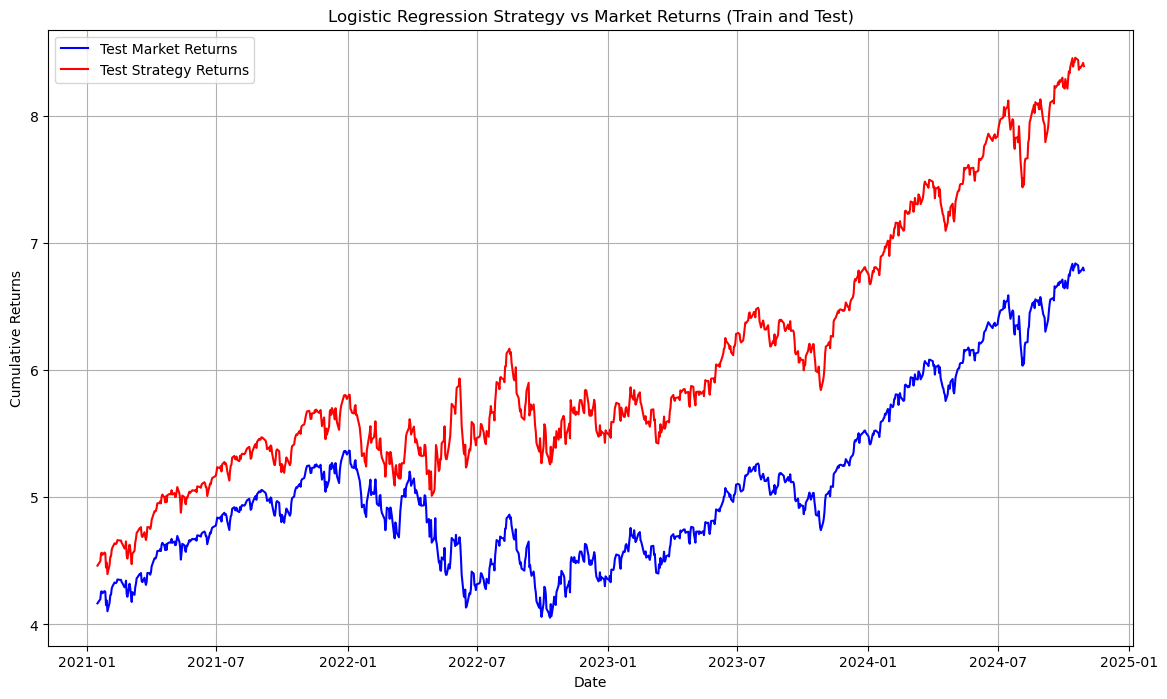

In [541]:
# Combined plotting for train and test data
plt.figure(figsize=(14, 8))
# # Train Data: Market and Strategy Returns
# plt.plot(np.exp(train_data['return'].cumsum()), label='Train Market Returns', color='green', linestyle='-')
# plt.plot(np.exp(train_data['strategy'].cumsum()), label='Train Strategy Returns', color='orange', linestyle='-')

# Test Data: Market and Strategy Returns
plt.plot(np.exp(test_data['cum_SPY_return']), label='Test Market Returns', color='blue', linestyle='-')
plt.plot(np.exp(test_data['cum_strategy_return']), label='Test Strategy Returns', color='red', linestyle='-')

# Plot configuration
plt.title('Logistic Regression Strategy vs Market Returns (Train and Test)')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid()
plt.show()

## RSI

#### The Relative Strength Index (RSI) is an indicator that uses the closing prices of an asset to identify oversold and overbought conditions. 

> Most commonly, RSI is calculated using a 14-day period, and measured on a scale from zero to 100. (It is an oscillator.)

> Traders usually buy an asset when it is oversold (when its RSI is below 30) and sell when it is overbought (when its RSI is above 70). 

> More extreme overbought and oversold levels, such as 80 and 20, are used less frequently, and imply stronger momentum.

#### You are asked to build a trading strategy with the following set of rules.

### <font color = green> NOTE: Apple (`AAPL`) as our security of interest. The `investment horizon` will be three years between 2015 and 2017; your `capital` is USD 100,000; and there is a USD 5 flat `commission fee` per trade.

- You can go long and short.
<br>

- To calculate RSI, use 14 periods (trading days).
<br>

- Enter a long position if RSI crosses the lower threshold (standard value of 30), moving upwards. Exit the position when RSI becomes higher than the middle level (value of 50).
<br>

- Enter a short position if RSI crosses the upper threshold (standard value of 70), moving downwards. Exit the position when RSI becomes less than 50.
<br>

- Only one position can be open at a time.

### <font color = green> NOTE: The RSI is defined as follows:
    
### Calculating the RSI first requires the RS which requires an average value of n-many previous trading days. 
<br>
    
- As discussed, a value of 14 days is common for the RSI calculation. 
<br>
    
- The first RS value requires the price from all 14 of the first trading days. Often, this is a source of confusion with the RSI given successive values only require the most recent. 
   
    
    Step 1. For 14 periods, calculate the difference in price from the current period and the previous period
    
    Step 2. For each period, record each positive change in price as a gain and each negative change as a loss
    
    Step 3. On the 14th period, calculate the arithmetic mean of the gains and losses for the entire 14 day period (e.g. gains / 14 & losses / 14)
    
    Step 4. Use these values to calculate the RS
    
### <center> $ RS = \frac{AverageGain}{AverageLoss} $
    
    Step 5. Use the RS value to calculate the RSI
    
    Step 6. For each proceeding period, use only the previous RSI value to calculate the next average value 
    by multiplying by our lookback period – 1 (e.g., 13 for a lookback of 14).
    
    Step 7. Add the value obtained in Step 6 to the current day’s value (run this for both the gains and losses)
    
### <center> $ RSI = 100 - \frac{100}{1 + RS} $

### Visualize your buy and sell positions.

In [549]:
import pandas as pd
import numpy as np

def rsi_strategy(data, rolling_window=14, buy_level=30, sell_level=70, unwind_level=50):
    """
    Compute RSI and generate trade signals.
    
    Parameters:
    - data: pd.Series
        Time series data (e.g., close prices).
    - rolling_window: int
        The lookback period for RSI calculation.
    - buy_level: int
        The RSI level to trigger a buy signal.
    - sell_level: int
        The RSI level to trigger a sell signal.
    - unwind_level: int
        The RSI level to trigger an unwind (neutral) signal.
        
    Returns:
    - pd.DataFrame
        A DataFrame containing RSI values and trade signals.
    """
    # Compute price changes
    price_change = data.diff().iloc[1:]
    gain = price_change.clip(lower=0)
    loss = -price_change.clip(upper=0)
    
    # Initial average gain and loss
    g_rs_init, l_rs_init = gain.iloc[:rolling_window].mean(), loss.iloc[:rolling_window].mean()
    
    # Initialize rolling gains and losses
    g_rs = g_rs_init
    l_rs = l_rs_init
    
    init_date = gain.index[rolling_window - 1]
    init_date_plus_1 = gain.index[rolling_window]
    
    # Initialize rolling series for gains and losses
    gl_rs_df = pd.DataFrame(
        {init_date: [g_rs, l_rs]}, index=["gain_rs", "loss_rs"]
    ).T
    
    # Compute rolling averages for gains and losses
    for d, (g, l) in pd.concat([gain, loss], axis=1).iloc[rolling_window:].iterrows():
        g_rs = ((g_rs * (rolling_window - 1)) + g) / rolling_window
        l_rs = ((l_rs * (rolling_window - 1)) + l) / rolling_window
        gl_rs_df.loc[d] = [g_rs, l_rs]
    
    # Compute RSI
    rs = gl_rs_df["gain_rs"] / gl_rs_df["loss_rs"]
    rsi = 100 - 100 / (1 + rs)
    
    # Generate RSI-based signals
    rsi_up = rsi.diff() > 0
    rsi_down = rsi.diff() < 0
    crossed_buy = (np.sign((rsi - buy_level) * (rsi - buy_level).shift(1)).fillna(1) == -1)
    crossed_unwind = (np.sign((rsi - unwind_level) * (rsi - unwind_level).shift(1)).fillna(1) == -1)
    crossed_sell = (np.sign((rsi - sell_level) * (rsi - sell_level).shift(1)).fillna(1) == -1)
    
    # Generate trade signals
    buy = rsi_up & crossed_buy
    unwind = crossed_unwind
    sell = rsi_down & crossed_sell
    
    # Create position series
    position_series = pd.Series(np.nan, index=rsi.index)
    position_series[buy] = 1
    position_series[unwind] = 0
    position_series[sell] = -1
    position_series.iloc[0] = 0
    position_series = position_series.ffill()
    
    # Combine RSI and positions into a DataFrame
    result = pd.DataFrame({
        "RSI": rsi,
        "Position": position_series
    })
    
    return result


In [586]:
stock = 'SPY'
start = dt.datetime(2005, 11, 1)
end = dt.datetime(2024, 10, 31)
df = yf.download(stock, start, end)

[*********************100%%**********************]  1 of 1 completed


In [588]:
# Example usage
data = df['Adj Close']
result = rsi_strategy(data, rolling_window=14, buy_level=40, sell_level=60, unwind_level=50)

result


,RSI,Position
2005-11-21,89.742845,0.0
2005-11-22,90.569940,0.0
2005-11-23,91.560749,0.0
2005-11-25,91.689501,0.0
2005-11-28,79.874105,0.0
...,...,...
2024-10-24,57.173581,-1.0
2024-10-25,56.860093,-1.0
2024-10-28,59.025454,-1.0
2024-10-29,60.156448,-1.0


In [589]:
result['return'] = np.log(df['Adj Close'] / df['Adj Close'].shift(1))
result['strategy'] = result['Position'].shift(1) * result['return']
result['cum_SPY_return'] = result['return'].cumsum().apply(np.exp)
result['cum_strategy_return'] = result['strategy'].cumsum().apply(np.exp)
result

,RSI,Position,return,strategy,cum_SPY_return,cum_strategy_return
2005-11-21,89.742845,0.0,0.005022,NaN,1.005035,NaN
2005-11-22,90.569940,0.0,0.004285,0.000000,1.009350,1.000000
2005-11-23,91.560749,0.0,0.005764,0.000000,1.015184,1.000000
2005-11-25,91.689501,0.0,0.000787,0.000000,1.015983,1.000000
2005-11-28,79.874105,0.0,-0.007104,-0.000000,1.008791,1.000000
...,...,...,...,...,...,...
2024-10-24,57.173581,-1.0,0.002160,-0.002160,6.640711,0.874594
2024-10-25,56.860093,-1.0,-0.000345,0.000345,6.638418,0.874896
2024-10-28,59.025454,-1.0,0.003087,-0.003087,6.658940,0.872200
2024-10-29,60.156448,-1.0,0.001617,-0.001617,6.669717,0.870791


<Axes: >

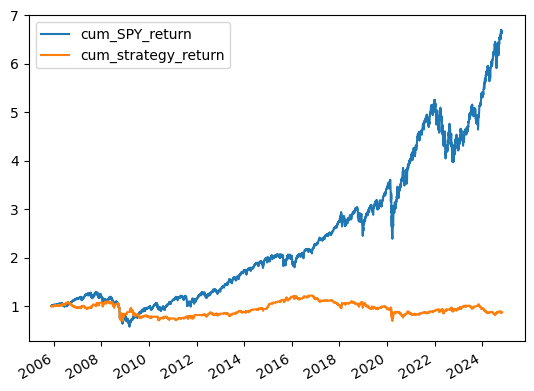

In [592]:
result[['cum_SPY_return','cum_strategy_return']].plot()

In [594]:
#try without unwind

In [633]:
import pandas as pd
import numpy as np

def rsi_strategy_reversed(data, rolling_window, buy_level, sell_level):
    """
    Compute RSI and generate reversed trade signals.
    
    Parameters:
    - data: pd.Series
        Time series data (e.g., close prices).
    - rolling_window: int
        The lookback period for RSI calculation.
    - buy_level: int
        The RSI level to trigger a sell signal (reversed logic).
    - sell_level: int
        The RSI level to trigger a buy signal (reversed logic).
        
    Returns:
    - pd.DataFrame
        A DataFrame containing RSI values and trade signals.
    """
    # Compute price changes
    price_change = data.diff().iloc[1:]
    gain = price_change.clip(lower=0)
    loss = -price_change.clip(upper=0)
    
    # Initial average gain and loss
    g_rs_init, l_rs_init = gain.iloc[:rolling_window].mean(), loss.iloc[:rolling_window].mean()
    
    # Initialize rolling gains and losses
    g_rs = g_rs_init
    l_rs = l_rs_init
    
    init_date = gain.index[rolling_window - 1]
    init_date_plus_1 = gain.index[rolling_window]
    
    # Initialize rolling series for gains and losses
    gl_rs_df = pd.DataFrame(
        {init_date: [g_rs, l_rs]}, index=["gain_rs", "loss_rs"]
    ).T
    
    # Compute rolling averages for gains and losses
    for d, (g, l) in pd.concat([gain, loss], axis=1).iloc[rolling_window:].iterrows():
        g_rs = ((g_rs * (rolling_window - 1)) + g) / rolling_window
        l_rs = ((l_rs * (rolling_window - 1)) + l) / rolling_window
        gl_rs_df.loc[d] = [g_rs, l_rs]
    
    # Compute RSI
    rs = gl_rs_df["gain_rs"] / gl_rs_df["loss_rs"]
    rsi = 100 - 100 / (1 + rs)
    
    # Generate RSI-based signals (reversed logic)
    rsi_up = rsi.diff() < 0
    rsi_down = rsi.diff() > 0
    crossed_buy = (np.sign((rsi - buy_level) * (rsi - buy_level).shift(1)).fillna(1) == -1)
    crossed_sell = (np.sign((rsi - sell_level) * (rsi - sell_level).shift(1)).fillna(1) == -1)
    
    # Reversed logic: buy -> sell, sell -> buy
    sell = rsi_up & crossed_buy  # Previously buy
    buy = rsi_down & crossed_sell  # Previously sell
    
    # Create position series
    position_series = pd.Series(np.nan, index=rsi.index)
    position_series[buy] = 1
    position_series[sell] = -1
    position_series.iloc[0] = 0
    position_series = position_series.ffill()
    
    # Combine RSI and positions into a DataFrame
    result = pd.DataFrame({
        "RSI": rsi,
        "Position": position_series
    })
    
    return result


In [651]:
data = df['Adj Close']
result = rsi_strategy(data, rolling_window=1, buy_level=40, sell_level=60)

print(result)


              RSI  Position
2005-11-02  100.0       0.0
2005-11-03  100.0       0.0
2005-11-04    0.0       1.0
2005-11-07  100.0      -1.0
2005-11-08    NaN      -1.0
...           ...       ...
2024-10-24  100.0      -1.0
2024-10-25    0.0       1.0
2024-10-28  100.0      -1.0
2024-10-29  100.0      -1.0
2024-10-30    0.0       1.0

[4780 rows x 2 columns]


In [652]:
result['return'] = np.log(df['Adj Close'] / df['Adj Close'].shift(1))
result['strategy'] = result['Position'].shift(1) * result['return']
result['cum_SPY_return'] = result['return'].cumsum().apply(np.exp)
result['cum_strategy_return'] = result['strategy'].cumsum().apply(np.exp)
result

,RSI,Position,return,strategy,cum_SPY_return,cum_strategy_return
2005-11-02,100.0,0.0,0.010403,NaN,1.010457,NaN
2005-11-03,100.0,0.0,0.004262,0.000000,1.014773,1.000000
2005-11-04,0.0,1.0,-0.001310,-0.000000,1.013445,1.000000
2005-11-07,100.0,-1.0,0.000982,0.000982,1.014441,1.000983
2005-11-08,NaN,-1.0,0.000000,-0.000000,1.014441,1.000983
...,...,...,...,...,...,...
2024-10-24,100.0,-1.0,0.002160,0.002160,6.896443,3.908172
2024-10-25,0.0,1.0,-0.000345,0.000345,6.894062,3.909521
2024-10-28,100.0,-1.0,0.003087,0.003087,6.915374,3.921607
2024-10-29,100.0,-1.0,0.001617,-0.001617,6.926566,3.915271


## MACD

In [658]:
df = df.rename(columns = {'Adj Close' : 'price'})

In [660]:
df["ema_12"] = df["price"].ewm(span = 12, min_periods = 12).mean()
df["ema_26"] = df["price"].ewm(span = 26, min_periods = 26).mean()

df["macd"] = df["ema_12"] - df["ema_26"]

df

,Open,High,Low,Close,price,Volume,ema_12,ema_26,macd
Date,,,,,,,,,
2005-11-01,120.580002,120.900002,120.220001,120.489998,83.991119,66365100,NaN,NaN,NaN
2005-11-02,120.169998,121.750000,120.129997,121.750000,84.869438,74012300,NaN,NaN,NaN
2005-11-03,122.150002,122.660004,121.750000,122.269997,85.231956,84897600,NaN,NaN,NaN
2005-11-04,122.400002,122.459999,121.550003,122.110001,85.120392,59156000,NaN,NaN,NaN
2005-11-07,122.370003,122.620003,121.849998,122.230003,85.204056,46765400,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2024-10-24,579.979980,580.059998,576.570007,579.239990,579.239990,34979900,579.475745,574.400675,5.075070
2024-10-25,581.510010,584.460022,578.080017,579.039978,579.039978,47268200,579.408704,574.744327,4.664377
2024-10-28,582.580017,582.710022,580.520020,580.830017,580.830017,30174700,579.627367,575.195119,4.432248


In [664]:
df["macd_signal"] =\
(
    df
    ["macd"]
    .ewm(span = 9)
    .mean()
)

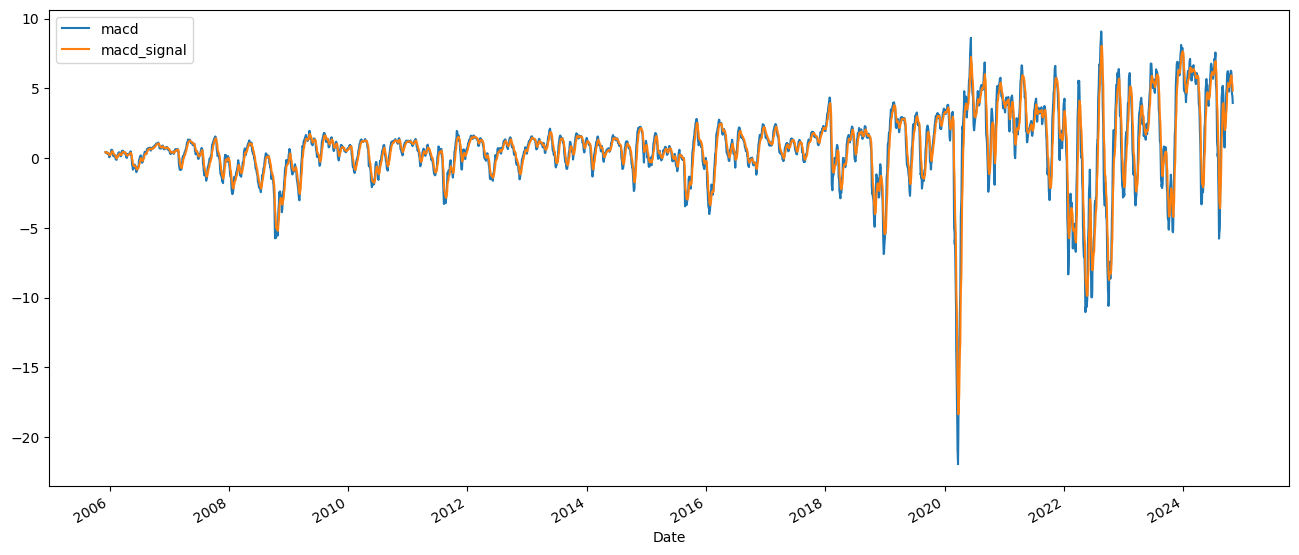

In [668]:
df["macd"].plot(figsize = [16, 7]
                      )

df["macd_signal"].plot()

plt.legend()

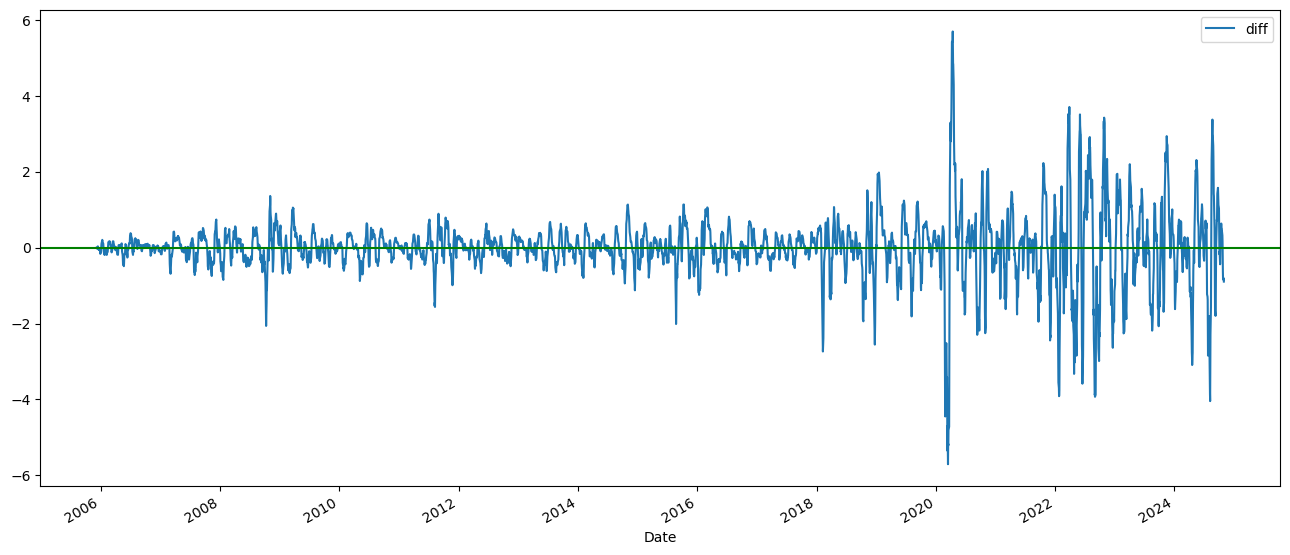

In [672]:
(
    df["macd"]
    -
    df["macd_signal"]
).plot(figsize = [16, 7],
       label = "diff"
      )

plt.axhline(0, color = "green")

plt.legend()

In [676]:
df["diff"] =\
(
    df["macd"]
    -
    df["macd_signal"]
)

# Position Cross Identification

df["position_cross"] =\
(
    np
    .sign(df["diff"] * df["diff"].shift(1)
         ) == -1
)

In [678]:
df["position_macd_direction"] =\
(
    np
    .sign(df["macd"]
          .diff()
         )
)

(
    df
    ["position_macd_direction"]
    .value_counts()
)

position_macd_direction
 1.0    2497
-1.0    2258
Name: count, dtype: int64

In [680]:
bullish = (df["position_macd_direction"] > 0) & df["position_cross"]

bearish = (df["position_macd_direction"] < 0) & df["position_cross"]

print(bullish.sum());print(bearish.sum())

200
200


Text(0.5, 1.0, 'Buy & Sell Signals on MACD')

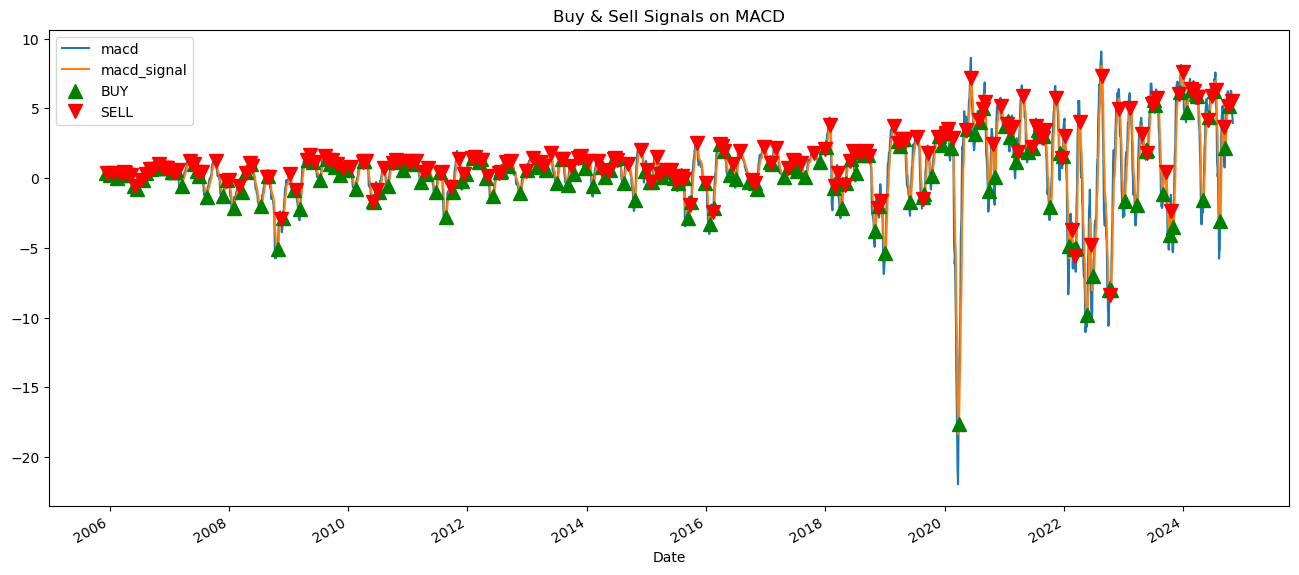

In [684]:
df["macd"].plot(figsize = [16, 7]
                      )

df["macd_signal"].plot()

plt\
.plot(
    df["macd"].loc[bullish].index,
    df["macd"].loc[bullish],
    "g^",
    label = "BUY",
    markersize = 10
)

plt\
.plot(
    df["macd"].loc[bearish].index,
    df["macd"].loc[bearish],
    "rv",
    label = "SELL",
    markersize = 10
)

plt.legend()
plt.title("Buy & Sell Signals on MACD")

Text(0.5, 1.0, 'Buy & Sell Signals on AAPL Adj. Close')

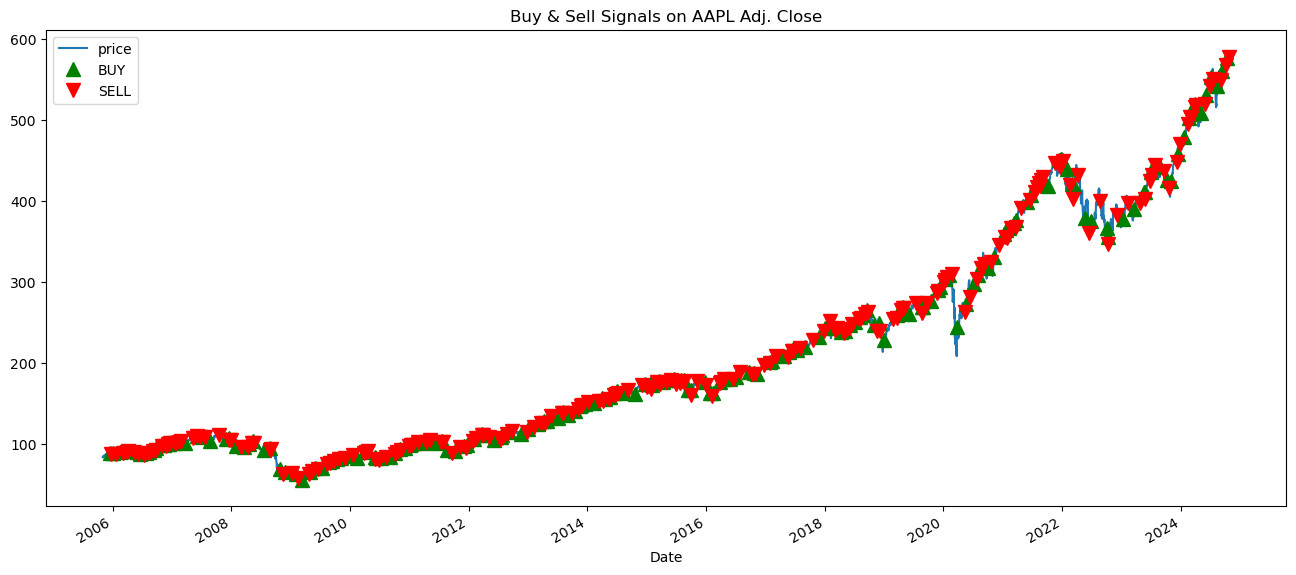

In [686]:
df["price"].plot(figsize = [16, 7]
                      )

plt\
.plot(
    df["price"].loc[bullish].index,
    df["price"].loc[bullish],
    "g^",
    label = "BUY",
    markersize = 10
)

plt\
.plot(
    df["price"].loc[bearish].index,
    df["price"].loc[bearish],
    "rv",
    label = "SELL",
    markersize = 10
)

plt.legend()
plt.title("Buy & Sell Signals on AAPL Adj. Close")

In [688]:
df

,Open,High,Low,Close,price,Volume,ema_12,ema_26,macd,macd_signal,diff,position_cross,position_macd_direction
Date,,,,,,,,,,,,,
2005-11-01,120.580002,120.900002,120.220001,120.489998,83.991119,66365100,NaN,NaN,NaN,NaN,NaN,False,NaN
2005-11-02,120.169998,121.750000,120.129997,121.750000,84.869438,74012300,NaN,NaN,NaN,NaN,NaN,False,NaN
2005-11-03,122.150002,122.660004,121.750000,122.269997,85.231956,84897600,NaN,NaN,NaN,NaN,NaN,False,NaN
2005-11-04,122.400002,122.459999,121.550003,122.110001,85.120392,59156000,NaN,NaN,NaN,NaN,NaN,False,NaN
2005-11-07,122.370003,122.620003,121.849998,122.230003,85.204056,46765400,NaN,NaN,NaN,NaN,NaN,False,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-24,579.979980,580.059998,576.570007,579.239990,579.239990,34979900,579.475745,574.400675,5.075070,5.700493,-0.625424,False,-1.0
2024-10-25,581.510010,584.460022,578.080017,579.039978,579.039978,47268200,579.408704,574.744327,4.664377,5.493270,-0.828894,False,-1.0
2024-10-28,582.580017,582.710022,580.520020,580.830017,580.830017,30174700,579.627367,575.195119,4.432248,5.281066,-0.848817,False,-1.0


In [690]:
df['position_macd_direction'].value_counts()

position_macd_direction
 1.0    2497
-1.0    2258
Name: count, dtype: int64

In [692]:
df["position"] =\
(
    np
    .where(bullish, 1,
           np.where(bearish, 
                    -1, np.nan)
          )
)

df.iloc[0].loc["position"] = 0

df["position"] =\
(
    df["position"]
    .ffill()
)

df["position"]

Date
2005-11-01    NaN
2005-11-02    NaN
2005-11-03    NaN
2005-11-04    NaN
2005-11-07    NaN
             ... 
2024-10-24   -1.0
2024-10-25   -1.0
2024-10-28   -1.0
2024-10-29   -1.0
2024-10-30   -1.0
Name: position, Length: 4781, dtype: float64

In [694]:
df["position t+1"] =\
(
    df
    ["position"]
    .shift(1)
)

In [698]:
df["base_log_return"] =\
(
    np
    .log(df["price"]
         /
         df["price"].shift(1)
        )
)

df["strategy"] =\
(
    df["base_log_return"]
    *
    df["position t+1"]
)

<Axes: xlabel='Date'>

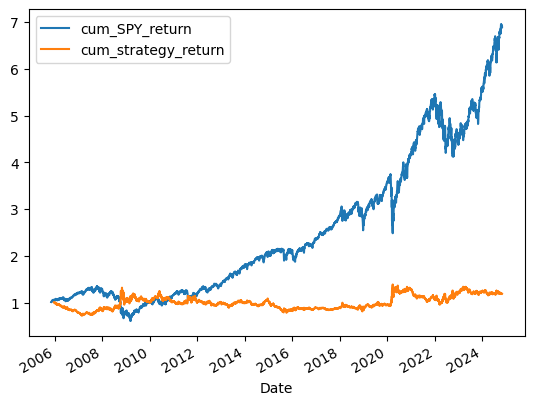

In [707]:
df["cum_strategy_return"] =\
( # Cumulative Returns (Total Return Index)
    df["strategy"]
    .cumsum()
    .apply(np.exp)
)

df['cum_SPY_return'] = df['base_log_return'].cumsum().apply(np.exp)

df[['cum_SPY_return','cum_strategy_return']].plot()

#Try hyperparameter tuning

In [728]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def macd_strategy(df, price_col='price', short_range=(10, 20), long_range=(25, 35), signal_range=(5, 90)):
    """
    MACD strategy with hyperparameter tuning for the best short, long, and signal periods.
    
    Parameters:
    - df: pd.DataFrame
        DataFrame containing the price data.
    - price_col: str
        The column name in `df` containing the price data.
    - short_range: tuple
        Range of values for the short EMA period (start, end).
    - long_range: tuple
        Range of values for the long EMA period (start, end).
    - signal_range: tuple
        Range of values for the signal EMA period (start, end).
        
    Returns:
    - dict
        Results containing the best parameters and cumulative strategy returns.
    - pd.DataFrame
        Updated DataFrame with calculated MACD values and signals.
    """
    best_params = {'short_period': None, 'long_period': None, 'signal_period': None, 'cumulative_return': -np.inf}
    df_results = pd.DataFrame()

    for short_period in range(*short_range):
        for long_period in range(*long_range):
            if short_period >= long_period:
                continue
            
            for signal_period in range(*signal_range):
                # Calculate EMAs and MACD
                df['ema_short'] = df[price_col].ewm(span=short_period, min_periods=short_period).mean()
                df['ema_long'] = df[price_col].ewm(span=long_period, min_periods=long_period).mean()
                df['macd'] = df['ema_short'] - df['ema_long']
                df['macd_signal'] = df['macd'].ewm(span=signal_period).mean()
                df['diff'] = df['macd'] - df['macd_signal']

                # Identify cross signals
                df['position_cross'] = np.sign(df['diff'] * df['diff'].shift(1)) == -1
                df['position_macd_direction'] = np.sign(df['macd'].diff())
                bullish = (df['position_macd_direction'] > 0) & df['position_cross']
                bearish = (df['position_macd_direction'] < 0) & df['position_cross']
                
                # Generate position column
                df['position'] = np.where(bullish, 1, np.where(bearish, -1, np.nan))
                df.iloc[0, df.columns.get_loc('position')] = 0
                df['position'] = df['position'].ffill()
                df['position t+1'] = df['position'].shift(1)

                # Calculate returns
                df['base_log_return'] = np.log(df[price_col] / df[price_col].shift(1))
                df['strategy'] = df['base_log_return'] * df['position t+1']
                df['cum_strategy_return'] = df['strategy'].cumsum().apply(np.exp)

                # Check cumulative returns for this parameter set
                cum_return = df['cum_strategy_return'].iloc[-1]
                if cum_return > best_params['cumulative_return']:
                    best_params.update({
                        'short_period': short_period,
                        'long_period': long_period,
                        'signal_period': signal_period,
                        'cumulative_return': cum_return
                    })
                    df_results = df.copy()

    # Plot the best result
    plt.figure(figsize=(16, 7))
    df_results[['cum_strategy_return']].plot(label='Strategy Return', legend=True)
    df_results[['base_log_return']].cumsum().apply(np.exp).plot(label='Buy & Hold Return', legend=True)
    plt.title("MACD Strategy vs Buy & Hold")
    plt.show()

    return best_params, df_results


[*********************100%%**********************]  1 of 1 completed


<Figure size 1600x700 with 0 Axes>

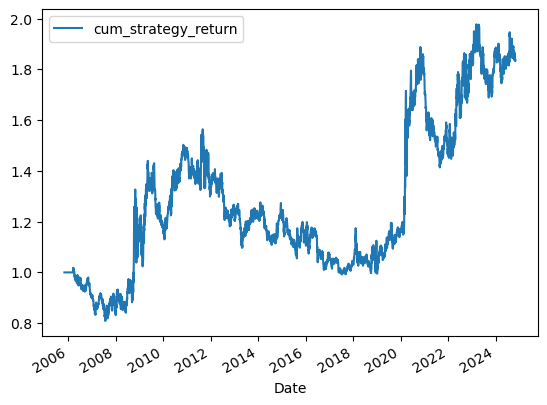

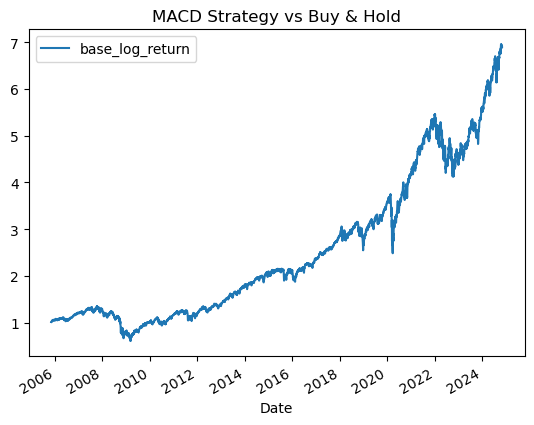

Best Parameters: {'short_period': 5, 'long_period': 86, 'signal_period': 10, 'cumulative_return': 1.8381428109479212}
Results DataFrame:                   Open        High         Low       Close      price  \
Date                                                                    
2005-11-01  120.580002  120.900002  120.220001  120.489998  83.991119   
2005-11-02  120.169998  121.750000  120.129997  121.750000  84.869438   
2005-11-03  122.150002  122.660004  121.750000  122.269997  85.231956   
2005-11-04  122.400002  122.459999  121.550003  122.110001  85.120392   
2005-11-07  122.370003  122.620003  121.849998  122.230003  85.204056   

              Volume  ema_short  ema_long  macd  macd_signal  diff  \
Date                                                                 
2005-11-01  66365100        NaN       NaN   NaN          NaN   NaN   
2005-11-02  74012300        NaN       NaN   NaN          NaN   NaN   
2005-11-03  84897600        NaN       NaN   NaN          NaN   NaN   
2

In [732]:
# Example price data
stock = 'SPY'
start = dt.datetime(2005, 11, 1)
end = dt.datetime(2024, 10, 31)
df = yf.download(stock, start, end)
df = df.rename(columns = {'Adj Close':'price'})

# Run the MACD strategy function
best_params, results = macd_strategy(
    df,
    price_col='price',
    short_range=(5, 20),
    long_range=(25, 100),
    signal_range=(5,90)
)

print("Best Parameters:", best_params)
print("Results DataFrame:", results.head())
